In [1]:
from IPython.display import display,HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

**<font color=Black size=5>
    @Project: FA defect code<br>
    <br>
    @Program Name: Module FA Reject Code-test <br>
    <br>
    @Author: Ge Chen  <br>
    <br>
    @Purpose: Perform analysis on association between FA Defect Code and HMFN failed register  <br>
    <br>
    <br>
</font>**

**<font color=IndianRed size=5>
    Part1. Import necessary modules<br>
</font>**

In [3]:
'''import useful module'''
"""
@Modules need to be import:
    1.numpy
    2.pandas
    3.matplotlib
    4.math
    5.sklearn
    6.xgboost
    7.itertools
    8.scipy
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from itertools import cycle
from sklearn.preprocessing import label_binarize
from scipy import interp
from scipy.stats import chi2_contingency
from sklearn.naive_bayes import MultinomialNB

**<font color=IndianRed size=5>
    Part 2: Data Preprocess for the first classifier
</font>**

<font color=Black size=4>
    Data preprocess steps for the 1st classifier are:
    
    
    1. Load data from original .csv file (The file path should be modified by your own, and the file path should be list type). Keep the useful information in DEF_PROD_FAIL.
    
    2. Combine the labels of small categories into "OTHERS" for the later correlation test.
    
    3. Perform Chi_square to test the correlation between each features and Defect code.
    
    4. Convert some original features into dummy variables. 
    
    5. Use groupby.last() to get the final Hard BIN Code and Reject code of each MID.
    
    6. Join all the dummy variables and final Hard BIN Code on MID to generate the feature matrix (One MID one line).
    
    7. Extract the Reject code column as labels. Also, combine small categories into "OTHERS" class.
    
    8. Drop the features with Std = 0
    
    9. Split training set and test set for the later modeling
</font>

In [4]:
"""
@Class Name:DataPreprocessor()
@use: load the original data from .csv files
"""
class DataLoader():
    def __init__(self, path):
        """
        @function: initinal function
        @input:
            1.path: the .csv file path, list type
        """
        self.path = path
    
    def Load(self):
        """
        @function: load function
        @input: 
            1.self: the class instance
        @return:
            1.df: original data, dataframe type
        """
        df = pd.DataFrame() # define a empty dataframe to store original data in multiple .csv files
        for path in self.path: # self.path is the .csv file path list
            df_temp = (pd.read_csv(path))[['MID', 'DEF_PROD_FAIL', 'Reject Code', 'Test Lable', 'DESIGN_ID', 'DEF_UNIQ_FAIL', 'HARD_BIN_NO', 'Component Type', 'Signal Type', 'END_ETIME']] # read the useful columns
            df = pd.concat([df, df_temp], ignore_index = True) # concat dataframe in different .csv files
        return df
        
        

In [5]:
'''use DataLoader Class to read original data in .csv files'''
pathlist = [r'C:/dataset/For_Ge_Chen.csv'] # should be modified by your own. Note, it should be a list type.
DL = DataLoader(pathlist)
data = DL.Load()

'''extract useful part from column "DEF_PROD_FAIL" (the string before "#") '''
data['Register'] = data['DEF_PROD_FAIL'].str.split('#', n = 0, expand=True)[0] # Example1: original DEF_PROD_FAIL is spd_eeprom_test_slave_addr#.7, useful path is spd_eeprom_test_slave_addr.
data.drop(['DEF_PROD_FAIL'], axis = 1, inplace = True) # drop the original DEF_PROD_FAIL

'''convert the values in ['DEF_UNIQ_FAIL'] to 0 or 1'''
data['DEF_UNIQ_FAIL'].fillna(0, inplace = True) # replace NAN with 0 
data['DEF_UNIQ_FAIL'][data['DEF_UNIQ_FAIL'] != 0] = 1 # replace Non-Null values with 1


c:\development\1stprj\1stprj\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [6]:
"""
@Class Name:DataPreprocessor()
@use: combine PTSPK and FSF, combine small categories into OTHERS
"""
class LabelCombination():    
    def Combine_PTSPK_FSF(self, labels):
        """
        @function: Combine_PTSPK_FSF
        @input:
            1.labels: labels which are waiting for the combination of PTSPK category and FSF category, series type
        @return: 
            1.labels after combination, series type
        """
        Labels = labels.copy()
        Labels.replace({'PTSPK': 'PTSPK_FSF'}, inplace = True)
        Labels.replace({'FSF': 'PTSPK_FSF'}, inplace = True)
        return Labels
    
    def Combine_Others(self, labels):
        """
        @function: CCombine_Others
        @input:
            1.labels: labels which are waiting for the combination of small categories, series type
        @return: 
            1.labels after combination, series type
        """
        Labels = labels.copy()
        MostCommonLabels = ['DCF', 'DCES', 'PTSPK', 'PTSPK_DCF_FSF', 'PTSPK_FSF']
        for i in range(len(Labels)):
            if Labels[i] not in MostCommonLabels:
                Labels[i] = 'OTHERS' 
        print (Labels.value_counts())
        return Labels

In [7]:
'''combine some categories in original labels. This is used in Correlation test'''
OriginalLabels = data['Reject Code'].copy() # make a copy from the original data
LC = LabelCombination()
CombinedLabels = LC.Combine_PTSPK_FSF(OriginalLabels) # combine PTSPK with FSF
CombinedLabels = LC.Combine_Others(CombinedLabels) # combine all the same categories

DCF          34919
DCES         22950
PTSPK_FSF    12526
OTHERS        5920
Name: Reject Code, dtype: int64


In [8]:
"""
@Class Name:CorrelationTest()
@use: to test the correlation between features and labels
"""
class CorrelationTest():
    def __init__(self, df):
        self.df = df
        
    def chi2(self, TestColumnName, Labels):
        """
        @function: chi2
        @input:
            1.TestColumnName: the column name of the feature which need to be tested
            1.Labels: labels
        @return: 
            1.pval: the pval of each pair of test column and labels
        """
        df_temp = self.df[['MID', TestColumnName]].copy()
        df_temp[TestColumnName].fillna('None', inplace = True)
        df_temp = pd.concat([df_temp, Labels], axis = 1)
        Chi2Matrix = df_temp.groupby(['Reject Code', TestColumnName]).count().unstack() # get the chi square table
        Chi2Matrix.fillna(0, inplace = True)
        pval = chi2_contingency(Chi2Matrix.values)[1] # use chi2_contingency() to calculate p value
        return pval       

In [9]:
'''calculate the p value of each pair of feature and label'''
CT = CorrelationTest(data)
TestColumnList = ['Test Lable', 'DESIGN_ID', 'DEF_UNIQ_FAIL', 'HARD_BIN_NO', 'Component Type', 'Signal Type'] # column name list
FeaturePval = {} # define a dict to store the column name and the corresponding p value
for column in TestColumnList:    
    pval_temp = CT.chi2(column,CombinedLabels)
    FeaturePval[column] = pval_temp
    

In [10]:
FeaturePval

{'Test Lable': 0.0,
 'DESIGN_ID': 0.0,
 'DEF_UNIQ_FAIL': 0.0,
 'HARD_BIN_NO': 0.0,
 'Component Type': 0.0,
 'Signal Type': 0.0}

In [11]:
"""
@Class Name:DataPreprocessor()
@usage: to regroup original data.
In original data set, each row only contains a single DEF_PROD_FAIL info, so multiple lines may belongs to one MID.
This class is used to aggregate those multiple lines (with same MID) in one row.
"""
class DataPreprocessor():
    def __init__(self, df):
        """
        @function: initinal function
        @input:
            1.df: original dataframe
        """
        self.df = df
    
    
    def GetDummyVariable(self, ColumnName):
        """
        @function: GetDummyVariable
        @input:
            1.ColumnName: the name of column which need to be converted into dummy variables
        @return:
            1. res: dummy variables
        @use: to convert the target column into dummy variables. The target columns include: Test Lable, DESIGN_ID, DEF_UNIQ_FAIL, Component Type, Signal Type, Register.
            A certain MID can only correspond one Test Lable, DESIGN_ID, Component Type, Signal Type.
            A certain MID can correspond multiple DEF_UNIQ_FAIL and Register.        
        """
        df_temp = self.df[['MID', ColumnName]].copy() # use column "MID" and the target column to generate a temp dataframe
        df_temp.drop_duplicates(inplace = True) # drop the duplicate rows in temp dataframe
        df_temp.index = df_temp['MID'] # use MID as index
        df_temp.drop(['MID'], axis = 1, inplace = True) # drop MID column because MID has become index 
        res = pd.get_dummies(df_temp) # use get_dummies() to convert series into a dataframe containing dummy variables
        if ColumnName in ['Test Lable', 'DESIGN_ID']:
            res.drop(res.columns[-1], axis=1, inplace = True) # because there will be multiple columns converted into dummy variables, so we need to drop a dummy variable to avoid multicollinearity.
        return res
    
    def GetFinalHBandRejCode(self):
        """
        @function: GetFinalHBandRejCode
        @return:
            1.The last row in each group (group by MID, sort by END Time, so each line contains the final time HardBinCode and Reject code of every MID)
        @use: to get the final hard bin code and reject code
        """
        df_temp = self.df[['MID', 'HARD_BIN_NO', 'END_ETIME', 'Reject Code']].copy() # make a copy to avoid modify original data
        return df_temp.sort_values('END_ETIME').groupby('MID').last() # group by MID, sort by END_ETIME, get the last row in each group
    
    def GetRecordNum(self):
        """
        @function: GetRecordNum
        @return:
            1.the row number of each MID. 
        @use: to get the row number of each MID. The row number is count by different END_ETIME (if multiple rows have same END_ETIME, they will be treated as one record)
        """        
        df_temp = self.df[['MID', 'END_ETIME']].copy()
        df_temp.drop_duplicates(inplace = True) # count with different END_ETIME
        return df_temp.groupby('MID').count()

In [12]:
'''regroup the original data, prepare the dataset for later modeling work'''
FP = DataPreprocessor(data) # create a DataPreprocessor object

'''convert target columns into dummy variables'''
df_TestLable = FP.GetDummyVariable('Test Lable').groupby('MID').sum() # 无一行全为0的情况，需要去除一个dummy variable防止多重共线性. 有1个MID对应2个不同的test lable，使用sum聚合成一行
df_DID = FP.GetDummyVariable('DESIGN_ID') # 无一行全为0的情况，需要去除一个dummy variable防止多重共线性
df_UniqFail = FP.GetDummyVariable('DEF_UNIQ_FAIL').groupby('MID').sum() # 有一行全为1的情况（即第一次测试时为unique fail, 后续测试更改为no unique fail，不需要去除一个dummy variable.经过sum()后，此MID下曾经有过的Unique fail状态都会变为1
df_DummyCompType = FP.GetDummyVariable('Component Type')  # 有一行全为0的情况（即此行在Component Type列下的值为空），不需要去除一个dummy variable
df_DummySignType = FP.GetDummyVariable('Signal Type').groupby('MID').sum()  # 有一行全为0的情况（即此行Signal Type列下的值为空），不需要去除一个dummy variable, 有1个MID对应2个不同的SignType，使用sum聚合成一行
df_DummyRegister = FP.GetDummyVariable('Register').groupby('MID').sum() # 有一行全为0的情况（即此行no first fai），不需要去除一个dummy variable.经过sum()后，此MID下所有fail的register都会变为1

'''get the final hard BIN code and reject code'''
df_FinalHBandRejCode = FP.GetFinalHBandRejCode() # 获得最后的hardBin和reject code

'''get the row number of each MID'''
df_RecordNum = FP.GetRecordNum() # 获得每个MID的fail记录条数（count by time，如果一个MID内有多条record但end time一样，这几条record只算作一条）
df_RecordNum.rename(columns = {'END_ETIME': 'Record Row Number'}, inplace = True)

In [13]:
"""
merge all the dummy variables, final HARD_BIN_CODE, final reject code and the row number of each MID.
Then get the dataset for the later modeling
"""
df_regroup = pd.concat([df_TestLable, df_DID, df_UniqFail, df_DummyCompType, \
                        df_FinalHBandRejCode, df_DummySignType, df_DummyRegister, df_RecordNum], axis = 1, sort = False)
print (df_regroup['Reject Code'].value_counts())
Labels_regroup = LC.Combine_PTSPK_FSF(df_regroup['Reject Code']) # combine PTSPK with FSF in regrouped dataset
Labels_regroup = LC.Combine_Others(Labels_regroup) # combine all the same categories in regrouped dataset
Feature_regroup = df_regroup.drop(['Reject Code', 'END_ETIME'], axis = 1) # drop the label column and get the feature matrix

DCF      7629
DCES     6011
PTSPK    4217
FSF       391
TF        317
EC1       237
PDC1      232
LF        227
PDC2      216
CL1       167
CL2       123
EC2       114
VSRN      114
VSCP      113
VSEP      104
MDM        98
BS1        60
EN         54
MPC2       49
GCL2       45
MPC1       44
NRSPK      35
VSBF       32
GCL1       32
BS2        20
NWSJ2      17
VSOT       17
VSR        15
DB         14
MSC1       13
NWSJ1      12
LVS1       12
TC1        12
BC         11
LVS2       11
MSC2       11
TC2         8
RPM         8
GEC1        3
COD         3
NRLB        2
NVSJ2       2
VSAR        2
GEC2        2
SB1         1
VSGEC       1
VSCMP       1
GTD         1
Name: Reject Code, dtype: int64
DCF          7629
DCES         6011
PTSPK_FSF    4608
OTHERS       2612
Name: Reject Code, dtype: int64


In [14]:
"""
@Class Name:FeatureFilter()
@usage: to drop the column with std = 0. In other words, drop the feature with same value
"""
class FeatureFilter():
    def SelectFeature(self, FeatureMatrix):
        """
        @function: SelectFeature
        @input:
            1.FeatureMatrix: feature matrix after regrouping
        @return:
            1.FeatureAfterFilter: feature matrix after filter
        """
        print ('feature number before filter:', FeatureMatrix.shape)
        FeatureStd = FeatureMatrix.std()
        FeatureStd = FeatureStd[FeatureStd > 0]
        FeatureAfterFilter = FeatureMatrix.loc[:, FeatureStd.index]
        print ('feature number after filter:', FeatureAfterFilter.shape)
        return FeatureAfterFilter    

In [15]:
'''drop the feature with std = 0.'''
FF = FeatureFilter()
FeatureAfterFilter = FF.SelectFeature(Feature_regroup)

feature number before filter: (20860, 778)
feature number after filter: (20860, 778)


In [16]:
'''split the train set and test set for the first classifier'''
x_train,x_test,y_train,y_test = train_test_split(FeatureAfterFilter, Labels_regroup, 
                                                                 test_size=0.3, random_state=0)
    


**<font color=IndianRed size=5>
    Part 3: Perform machine learning algorithms to build 1st classifier
</font>**


<font color=Black size=4>
    The steps in Modeling Part for the 1st classifier are:
        
    1. Perform Logistic Regression.
    
    2. Plot ROC curve for LR.
    
    3. Perform XGBoost.
    
    4. Use gridsearchCV to find the best parameters for XGBoost. 
    
    5. Plot ROC curve for LR.
    
    6. XGBoost shows a better accuracy than LR. Choose XGBoost model as the 1st classifier.
    
    7. Show the feature importance of XGBoost classifier.
</font>

In [17]:
"""
@Class Name:logistic regression
@usage: to build a logistic regression model to predict the FA defect code for each MID
"""
class LRPredictor():
    def __init__(self, x_train, x_test, y_train, y_test):
        """
        @function: initinal function
        @input:
            1.x_train: feature matrix in training set, dataframe type
            2.x_test: feature matrix in test set, dataframe type
            3.y_train, labels in training set, series type
            4.y_test, labels in test set, series type
        @use: to define some necessary parameters for this class
        """
        self.__xtrain = x_train
        self.__ytrain = y_train
        self.__xtest = x_test
        self.__ytest = y_test
        
    def calc(self):
        """
        @function: calc
        @input: class instance
        @return:
            1. lr: logistic regression model after fitting
            2. ConfMatrix: confusion matrix of test set
            3. ClassReport: a matrix include precision, recall, F1-score of each category
            4. y_pred: predicted labels of test set
            5. y_score: probability in every category, predicted by the fitted model. It is used to plot the ROC_AUC figure.
                        For example: The y_score for one sample may be [8.27757079e-04, 7.44843724e-01, 8.65239234e-04, 2.53463279e-01],
                                     it represent that this sample has 0.0827% probability in the first category, 74.4% probability in the second category.
        @use: to define some necessary parameters for this class
        """ 
        
        ''' 
        define the logistic regression model.
        @Parameters:
            1. penalty='l2':L2 norm used in the penalization
            2. solver='newton-cg' : choose newton-cg to optimize the cost function. 利用海森矩阵(二阶导数矩阵)优化cost function
            3. multi_class='multinomial': the loss minimised is the multinomial loss fit across the entire probability distribution
        '''
        lr = LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial') # define the logistic regression model.        
        lr.fit(self.__xtrain, self.__ytrain) # train the LR model
        y_pred = lr.predict(self.__xtest) # predict the labels
        y_score = lr.predict_proba(self.__xtest) # get the probability for each category
        classname = lr.classes_ # get the class name list of prediction
                
        ConfMatrix = metrics.confusion_matrix(self.__ytest, y_pred, labels = classname) # generate the confusion matrix, np.array type
        ConfMatrix = pd.DataFrame(ConfMatrix) # convert np.array into dataframe
        ConfMatrix.index = classname # add the index for confusion matrix
        ConfMatrix.columns = classname # add the column name for confusion matrix
        ClassReport = metrics.classification_report(self.__ytest, y_pred) # generate the classification report
        Accuracy = metrics.accuracy_score(self.__ytest, y_pred) # get the accuracy for the prediction
        print ('Accuracy is:', Accuracy)
        print ('ConfMatrix is:')
        print (ConfMatrix)
        print ('Classification_report is')
        print (ClassReport)
        
        return lr, ConfMatrix, ClassReport, y_pred, y_score
    
    def PlotFeatureImportance(self, FeatureList, lr, n):
        """
        @function: PlotFeatureImportance
        @input: 
            1. FeatureList: Feature list in training set
            2. lr: logistic regression model after training
            3. n: number of most important features you want to show
    
        @use: to show the feature importance for Logistic regression model
        """         
        
        FeatureImportance = pd.DataFrame(lr.coef_).apply(lambda x: abs(x)).mean()
        FeatureImportance = 100 * FeatureImportance / FeatureImportance.max()
        sorted_idx = np.argsort(FeatureImportance)
        pos = np.arange(sorted_idx.shape[0] + 5)
        
        featfig = plt.figure()
        featax = featfig.add_subplot(1, 1, 1)
        featax.barh(pos[:n], FeatureImportance[sorted_idx][:n], align = 'center')
        featax.set_yticks(pos[:n])
        featax.set_yticklabels(np.array(FeatureList)[sorted_idx][:n], fontsize = 8)
        featax.set_xlabel('Relative Feature Importance')
        
        #plt.tight_layout()
        plt.show()

In [18]:
"""
@Class Name:ROC_AUC_printer
@usage: to plot ROC curves for multiple classification problem.
Please refer: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
"""
class ROC_AUC_printer():
    def __init__(self, y_test, y_score):
        """
        @function: initinal function
        @input:
            1.y_test, labels in test set, series type
            2.y_score, probability in every category
        @use: to define some necessary parameters for this class
        """        
        self.__ytest = y_test
        self.__yscore = y_score
        
    def calc(self, classname):
        """
        @function: calc
        @input:
            1.classname, the class name list
        @return:
            1.fpr, false positive rates
            2.tpr, true false positive rates
            3.roc_auc, a dict to store AUC for each category, micro-average and macro-average.
        @use: to calculate AUC
        """    
        y = label_binarize(self.__ytest, classes = classname) # Binarize labels in a one-vs-all fashion
        n_classes = y.shape[1] # class number
                        
        '''Compute ROC curve and ROC area for each class'''
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):  
            fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], self.__yscore[:, i])
            roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
        '''Compute micro-average ROC curve and ROC area'''
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), self.__yscore.ravel())
        roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
        
        '''Compute macro-average ROC curve and ROC area'''
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])        
        return fpr, tpr, roc_auc
    
    def Plot(self, fpr, tpr, roc_auc, classname):
        """
        @function: Plot
        @input:
            1.fpr, false positive rates
            2.tpr, true false positive rates
            3.roc_auc, a dict to store AUC for each category, micro-average and macro-average.
            4.classname, class name list

        @use: to plot ROC curve for multiple classification model. It plots ROC curve for every single category as well as the micro-average and macro-average ROC curve.
        """    
        lw = 2 # line width
        plt.figure(figsize = (10, 8)) # define figure size
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4) # plot micro-average ROC curve

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4) # plot micro-average ROC curve

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'violet', 'yellow']) # define line colors
        curvelabels = classname # give the class names
        for i, color in zip(range(len(classname)), colors): # plot ROC curve for each category
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(curvelabels[i], roc_auc[i]))

        '''define some parameters for plotting'''
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        
    def Plot2(self, fpr, tpr, roc_auc):
        """
        @function: Plot2
        @input:
            1.fpr, false positive rates
            2.tpr, true false positive rates
            3.roc_auc, a dict to store AUC for each category, micro-average and macro-average.

        @use: to plot ROC curve for multiple classification model. It only plots micro-average and macro-average ROC curve. It won't plot ROV curve for every category.
             It is almost the same with Plot() function.
        """    
        lw = 2
        plt.figure(figsize = (10, 8))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()

In [19]:
'''perform Logistic Regression to predict FA defect code for 1st test set'''
LRP = LRPredictor(x_train,x_test,y_train,y_test)
Model_LR, ConfMatrix_LR, ClassReport_LR, y_pred_LR, y_score_LR = LRP.calc()

Accuracy is: 0.8819111537232343
ConfMatrix is:
           DCES   DCF  OTHERS  PTSPK_FSF
DCES       1730    11       0          1
DCF           6  2064      61        188
OTHERS        2    68     616        113
PTSPK_FSF     2   264      23       1109
Classification_report is
              precision    recall  f1-score   support

        DCES       0.99      0.99      0.99      1742
         DCF       0.86      0.89      0.87      2319
      OTHERS       0.88      0.77      0.82       799
   PTSPK_FSF       0.79      0.79      0.79      1398

   micro avg       0.88      0.88      0.88      6258
   macro avg       0.88      0.86      0.87      6258
weighted avg       0.88      0.88      0.88      6258



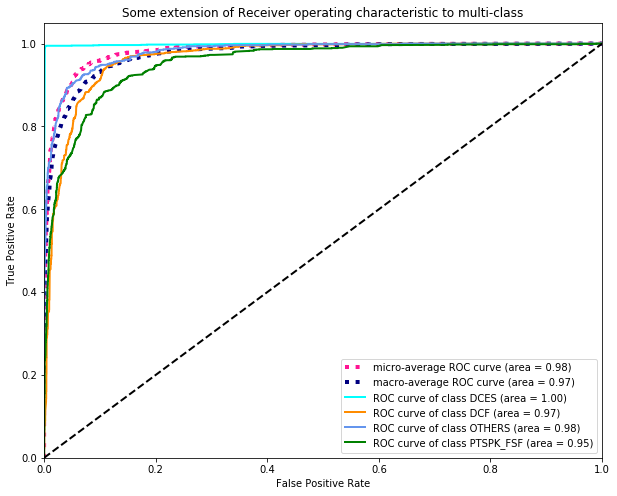

In [20]:
'''use ROC_AUC class to plot ROC curve for each category in 1st classifier'''
RA1_LR = ROC_AUC_printer(y_test, y_score_LR)
fpr, tpr, roc_auc = RA1_LR.calc(ConfMatrix_LR.index)
RA1_LR.Plot(fpr, tpr, roc_auc, ConfMatrix_LR.index)

In [21]:
"""
@Class Name:XGBoostPredictor
@use: use XGBoost to predict the FA dect code
"""
class XGBoostPredictor():
    def DefineInitParam(self):
        """
        @function: DefineInitParam
        @return: initial parameters for XGBoost, dict type
        @use: to define the initial parametes for XGBoost Classifier
        """            
        params = {}
        params['n_estimators'] = 100
        params['max_depth'] = 4
        params['min_child_weight'] = 3
        params['gamma'] = 0
        params['subsample'] = 0.8
        params['colsample_bytree'] = 0.8
        params['scale_pos_weight'] = 1
        params['nthread'] = 7
        params['objective'] = 'multi:softmax'
        params['seed'] = 27
        params['learning_rate'] = 0.1
        return params
            
    def FindBestParam(self, x_train, x_test, y_train, y_test, initialparams, adjustparams):
        """
        @function: FindBestParam
        @input:
            1. x_train, feature matrix in training set
            2. x_test, feature matrix in test set
            3. y_train, labels in training set
            4. y_test, lables in test set
            5. initialparams, initial parameters, dict type
            6. adjustparams, parameters to adjust. dict type
        @return: 
            1. gsearch1, GridSearchCV class object.
        @use: to adjust paramters to improve the model
        """   
        adjustkeys = adjustparams.keys() # get the names of parameters which need to be adjusted 
        for key in adjustkeys: # drop the term in initial parameter dict. 
            initialparams.pop(key)
        print ("unchanged params:", initialparams)
        print ("adjust params:", adjustparams)       
        fit_params = {"eval_set":[(x_test, y_test)], "early_stopping_rounds":50, "eval_metric":"mlogloss"} # define evaluation parameters for fitting
        gsearch1 = GridSearchCV(XGBClassifier(**initialparams), adjustparams, 
                                scoring = 'accuracy', cv = 3, verbose=4, n_jobs = 1) # build a gridsearchCV to find the best parameters       
        gsearch1.fit(x_train, y_train, **fit_params) # train the model
        print (gsearch1.best_params_)
        print (gsearch1.best_score_) #show the best score
        return gsearch1
    
    def Fit(self, params, x_train, x_test, y_train, y_test):
        """
        @function: Fit
        @input:
            1. params, XGBClassifier paramters
            2. x_train, feature matrix in training set
            3. x_test, feature matrix in test set
            4. y_train, labels in training set
            5. y_test, lables in test set
        @return: 
            1. ConfMatrix: confusion matrix of test set
            2. ClassReport: a matrix include precision, recall, F1-score of each category
            3. y_pred: predicted labels of test set
            4. y_score: probability in every category, predicted by the fitted model. It is used to plot the ROC_AUC figure.
        @use: to get the confusion matrix, classification report and accuracy of this model
        """ 
        
        '''define the parameters for XGBClassifier, details can be find in https://xgboost.readthedocs.io/en/latest/python/python_api.html'''
        clf = XGBClassifier(n_estimators = params['n_estimators'], max_depth = params['max_depth'], 
                             min_child_weight = params['min_child_weight'], learning_rate =params['learning_rate'], 
                             gamma=params['gamma'], subsample=params['subsample'], 
                            colsample_bytree=params['colsample_bytree'], n_jobs=6,
                             objective= 'multi:softmax', scale_pos_weight=1, seed=27, verbosity = 4) 
        
        fit_params = {"eval_set":[(x_test, y_test)], "early_stopping_rounds":50, "eval_metric":"mlogloss"} # define evaluation parameters for fitting. 
                                                                                                           # mlogloss, please refer to http://wiki.fast.ai/index.php/Log_Loss
        clf.fit(x_train, y_train, **fit_params) # train the model
        y_pred = clf.predict(x_test) # predict the labels
        y_score = clf.predict_proba(x_test)# get the probability for each category
        classname = clf.classes_ # get the class name list of prediction
        
        '''print the accuracy'''
        Accuracy = metrics.accuracy_score(y_test, y_pred) # get the accuracy for the prediction
        print ('Accuracy is:', Accuracy)
        
        '''generate the confusion matrix'''
        ConfMatrix = metrics.confusion_matrix(y_test, y_pred)
        ConfMatrix = pd.DataFrame(ConfMatrix)
        ConfMatrix.index = classname
        ConfMatrix.columns = classname
        
        '''generate the classification report'''
        ClassReport = metrics.classification_report(y_test, y_pred)
        print ('ConfMatrix is:')
        print (ConfMatrix)
        print ('classification_report is')
        print (ClassReport)
        return ConfMatrix, ClassReport, clf, y_pred, y_score

In [370]:
"""
use XGBoost to predict the FA defect code for the 1st test set. The steps are:
    1. define initial parameters
    2. define adjust parameters. The sequence of parameters
        a. n_estimators and max_depth
        b. .....
    3. use gridsearchCV to find the best parameters.
    4. use the best parameters to train the XGBoost classifier. Predict the labels for 1st test set. Output confusion matrix. 
    5. Plot ROC curve
    6. show feature importance
"""
print ('---------use original features, y is combined-----------')
xgb1 = XGBoostPredictor()
print ('data without TSVD, labels are str')
initialps = xgb1.DefineInitParam()
adjustps = {'n_estimators': [500, 1000, 1500], 'max_depth' : [6, 8, 10]}
gsearchresult1 = xgb1.FindBestParam(x_train,x_test,y_train,y_test, initialps, adjustps)
bestparams = gsearchresult1.best_params_  
initialps['n_estimators'] = bestparams['n_estimators']
initialps['max_depth'] = bestparams['max_depth']

---------use original features, y is combined-----------
data without TSVD, labels are str
unchanged params: {'min_child_weight': 3, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'scale_pos_weight': 1, 'nthread': 7, 'objective': 'multi:softmax', 'seed': 27, 'learning_rate': 0.1}
adjust params: {'n_estimators': [500, 1000, 1500], 'max_depth': [6, 8, 10]}
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=6, n_estimators=500 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0]	validation_0-mlogloss:1.25268
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.14525
[2]	validation_0-mlogloss:1.05787
[3]	validation_0-mlogloss:0.979666
[4]	validation_0-mlogloss:0.912725
[5]	validation_0-mlogloss:0.855528
[6]	validation_0-mlogloss:0.804685
[7]	validation_0-mlogloss:0.766995
[8]	validation_0-mlogloss:0.728202
[9]	validation_0-mlogloss:0.69384
[10]	validation_0-mlogloss:0.663123
[11]	validation_0-mlogloss:0.634704
[12]	validation_0-mlogloss:0.608003
[13]	validation_0-mlogloss:0.58513
[14]	validation_0-mlogloss:0.56334
[15]	validation_0-mlogloss:0.543498
[16]	validation_0-mlogloss:0.52662
[17]	validation_0-mlogloss:0.511008
[18]	validation_0-mlogloss:0.496909
[19]	validation_0-mlogloss:0.483127
[20]	validation_0-mlogloss:0.471069
[21]	validation_0-mlogloss:0.460329
[22]	validation_0-mlogloss:0.449621
[23]	validation_0-mlogloss:0.43975
[24]	validation_0-mlogloss:0.431785
[25]	validation_0-mlogloss:0.424425
[26]	validati

[224]	validation_0-mlogloss:0.293289
[225]	validation_0-mlogloss:0.293318
[226]	validation_0-mlogloss:0.293327
[227]	validation_0-mlogloss:0.293255
[228]	validation_0-mlogloss:0.2932
[229]	validation_0-mlogloss:0.293075
[230]	validation_0-mlogloss:0.293048
[231]	validation_0-mlogloss:0.292984
[232]	validation_0-mlogloss:0.293063
[233]	validation_0-mlogloss:0.293024
[234]	validation_0-mlogloss:0.293017
[235]	validation_0-mlogloss:0.293035
[236]	validation_0-mlogloss:0.29295
[237]	validation_0-mlogloss:0.292974
[238]	validation_0-mlogloss:0.292994
[239]	validation_0-mlogloss:0.292951
[240]	validation_0-mlogloss:0.292937
[241]	validation_0-mlogloss:0.293022
[242]	validation_0-mlogloss:0.292978
[243]	validation_0-mlogloss:0.292913
[244]	validation_0-mlogloss:0.292942
[245]	validation_0-mlogloss:0.292907
[246]	validation_0-mlogloss:0.292848
[247]	validation_0-mlogloss:0.292823
[248]	validation_0-mlogloss:0.292875
[249]	validation_0-mlogloss:0.292897
[250]	validation_0-mlogloss:0.292828
[251

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s


[0]	validation_0-mlogloss:1.25402
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.15694
[2]	validation_0-mlogloss:1.06746
[3]	validation_0-mlogloss:0.990658
[4]	validation_0-mlogloss:0.923026
[5]	validation_0-mlogloss:0.866598
[6]	validation_0-mlogloss:0.817855
[7]	validation_0-mlogloss:0.772362
[8]	validation_0-mlogloss:0.733313
[9]	validation_0-mlogloss:0.696579
[10]	validation_0-mlogloss:0.664102
[11]	validation_0-mlogloss:0.635972
[12]	validation_0-mlogloss:0.609034
[13]	validation_0-mlogloss:0.584712
[14]	validation_0-mlogloss:0.563608
[15]	validation_0-mlogloss:0.545681
[16]	validation_0-mlogloss:0.529759
[17]	validation_0-mlogloss:0.515325
[18]	validation_0-mlogloss:0.500595
[19]	validation_0-mlogloss:0.486926
[20]	validation_0-mlogloss:0.47535
[21]	validation_0-mlogloss:0.463935
[22]	validation_0-mlogloss:0.454054
[23]	validation_0-mlogloss:0.445146
[24]	validation_0-mlogloss:0.436934
[25]	validation_0-mlogloss:0.428771
[26]	vali

[223]	validation_0-mlogloss:0.296131
[224]	validation_0-mlogloss:0.296143
[225]	validation_0-mlogloss:0.296262
[226]	validation_0-mlogloss:0.29625
[227]	validation_0-mlogloss:0.296236
[228]	validation_0-mlogloss:0.296242
[229]	validation_0-mlogloss:0.296194
[230]	validation_0-mlogloss:0.296237
[231]	validation_0-mlogloss:0.296229
[232]	validation_0-mlogloss:0.296212
[233]	validation_0-mlogloss:0.296174
[234]	validation_0-mlogloss:0.2962
[235]	validation_0-mlogloss:0.296223
[236]	validation_0-mlogloss:0.296188
[237]	validation_0-mlogloss:0.296195
[238]	validation_0-mlogloss:0.296217
[239]	validation_0-mlogloss:0.296228
[240]	validation_0-mlogloss:0.296222
[241]	validation_0-mlogloss:0.296229
[242]	validation_0-mlogloss:0.296396
[243]	validation_0-mlogloss:0.296322
[244]	validation_0-mlogloss:0.296296
[245]	validation_0-mlogloss:0.296366
[246]	validation_0-mlogloss:0.296354
[247]	validation_0-mlogloss:0.296449
[248]	validation_0-mlogloss:0.296483
[249]	validation_0-mlogloss:0.296603
[250

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.9min remaining:    0.0s


[0]	validation_0-mlogloss:1.25447
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.15726
[2]	validation_0-mlogloss:1.06765
[3]	validation_0-mlogloss:0.990551
[4]	validation_0-mlogloss:0.921907
[5]	validation_0-mlogloss:0.865016
[6]	validation_0-mlogloss:0.816011
[7]	validation_0-mlogloss:0.769855
[8]	validation_0-mlogloss:0.73065
[9]	validation_0-mlogloss:0.694114
[10]	validation_0-mlogloss:0.661913
[11]	validation_0-mlogloss:0.633054
[12]	validation_0-mlogloss:0.606121
[13]	validation_0-mlogloss:0.581826
[14]	validation_0-mlogloss:0.560175
[15]	validation_0-mlogloss:0.541916
[16]	validation_0-mlogloss:0.525621
[17]	validation_0-mlogloss:0.511067
[18]	validation_0-mlogloss:0.496551
[19]	validation_0-mlogloss:0.482471
[20]	validation_0-mlogloss:0.470675
[21]	validation_0-mlogloss:0.458809
[22]	validation_0-mlogloss:0.448866
[23]	validation_0-mlogloss:0.440045
[24]	validation_0-mlogloss:0.431593
[25]	validation_0-mlogloss:0.42384
[26]	valid

[224]	validation_0-mlogloss:0.293104
[225]	validation_0-mlogloss:0.293159
[226]	validation_0-mlogloss:0.293155
[227]	validation_0-mlogloss:0.293024
[228]	validation_0-mlogloss:0.292985
[229]	validation_0-mlogloss:0.292987
[230]	validation_0-mlogloss:0.292973
[231]	validation_0-mlogloss:0.292989
[232]	validation_0-mlogloss:0.293038
[233]	validation_0-mlogloss:0.292884
[234]	validation_0-mlogloss:0.292794
[235]	validation_0-mlogloss:0.292738
[236]	validation_0-mlogloss:0.292742
[237]	validation_0-mlogloss:0.292716
[238]	validation_0-mlogloss:0.292747
[239]	validation_0-mlogloss:0.292686
[240]	validation_0-mlogloss:0.292618
[241]	validation_0-mlogloss:0.292597
[242]	validation_0-mlogloss:0.292643
[243]	validation_0-mlogloss:0.292653
[244]	validation_0-mlogloss:0.292542
[245]	validation_0-mlogloss:0.292483
[246]	validation_0-mlogloss:0.292438
[247]	validation_0-mlogloss:0.292383
[248]	validation_0-mlogloss:0.292424
[249]	validation_0-mlogloss:0.292381
[250]	validation_0-mlogloss:0.292295
[

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.0min remaining:    0.0s


[0]	validation_0-mlogloss:1.25268
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.14525
[2]	validation_0-mlogloss:1.05787
[3]	validation_0-mlogloss:0.979666
[4]	validation_0-mlogloss:0.912725
[5]	validation_0-mlogloss:0.855528
[6]	validation_0-mlogloss:0.804685
[7]	validation_0-mlogloss:0.766995
[8]	validation_0-mlogloss:0.728202
[9]	validation_0-mlogloss:0.69384
[10]	validation_0-mlogloss:0.663123
[11]	validation_0-mlogloss:0.634704
[12]	validation_0-mlogloss:0.608003
[13]	validation_0-mlogloss:0.58513
[14]	validation_0-mlogloss:0.56334
[15]	validation_0-mlogloss:0.543498
[16]	validation_0-mlogloss:0.52662
[17]	validation_0-mlogloss:0.511008
[18]	validation_0-mlogloss:0.496909
[19]	validation_0-mlogloss:0.483127
[20]	validation_0-mlogloss:0.471069
[21]	validation_0-mlogloss:0.460329
[22]	validation_0-mlogloss:0.449621
[23]	validation_0-mlogloss:0.43975
[24]	validation_0-mlogloss:0.431785
[25]	validation_0-mlogloss:0.424425
[26]	validati

[224]	validation_0-mlogloss:0.293289
[225]	validation_0-mlogloss:0.293318
[226]	validation_0-mlogloss:0.293327
[227]	validation_0-mlogloss:0.293255
[228]	validation_0-mlogloss:0.2932
[229]	validation_0-mlogloss:0.293075
[230]	validation_0-mlogloss:0.293048
[231]	validation_0-mlogloss:0.292984
[232]	validation_0-mlogloss:0.293063
[233]	validation_0-mlogloss:0.293024
[234]	validation_0-mlogloss:0.293017
[235]	validation_0-mlogloss:0.293035
[236]	validation_0-mlogloss:0.29295
[237]	validation_0-mlogloss:0.292974
[238]	validation_0-mlogloss:0.292994
[239]	validation_0-mlogloss:0.292951
[240]	validation_0-mlogloss:0.292937
[241]	validation_0-mlogloss:0.293022
[242]	validation_0-mlogloss:0.292978
[243]	validation_0-mlogloss:0.292913
[244]	validation_0-mlogloss:0.292942
[245]	validation_0-mlogloss:0.292907
[246]	validation_0-mlogloss:0.292848
[247]	validation_0-mlogloss:0.292823
[248]	validation_0-mlogloss:0.292875
[249]	validation_0-mlogloss:0.292897
[250]	validation_0-mlogloss:0.292828
[251

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.3min remaining:    0.0s


[0]	validation_0-mlogloss:1.25402
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.15694
[2]	validation_0-mlogloss:1.06746
[3]	validation_0-mlogloss:0.990658
[4]	validation_0-mlogloss:0.923026
[5]	validation_0-mlogloss:0.866598
[6]	validation_0-mlogloss:0.817855
[7]	validation_0-mlogloss:0.772362
[8]	validation_0-mlogloss:0.733313
[9]	validation_0-mlogloss:0.696579
[10]	validation_0-mlogloss:0.664102
[11]	validation_0-mlogloss:0.635972
[12]	validation_0-mlogloss:0.609034
[13]	validation_0-mlogloss:0.584712
[14]	validation_0-mlogloss:0.563608
[15]	validation_0-mlogloss:0.545681
[16]	validation_0-mlogloss:0.529759
[17]	validation_0-mlogloss:0.515325
[18]	validation_0-mlogloss:0.500595
[19]	validation_0-mlogloss:0.486926
[20]	validation_0-mlogloss:0.47535
[21]	validation_0-mlogloss:0.463935
[22]	validation_0-mlogloss:0.454054
[23]	validation_0-mlogloss:0.445146
[24]	validation_0-mlogloss:0.436934
[25]	validation_0-mlogloss:0.428771
[26]	vali

[223]	validation_0-mlogloss:0.296131
[224]	validation_0-mlogloss:0.296143
[225]	validation_0-mlogloss:0.296262
[226]	validation_0-mlogloss:0.29625
[227]	validation_0-mlogloss:0.296236
[228]	validation_0-mlogloss:0.296242
[229]	validation_0-mlogloss:0.296194
[230]	validation_0-mlogloss:0.296237
[231]	validation_0-mlogloss:0.296229
[232]	validation_0-mlogloss:0.296212
[233]	validation_0-mlogloss:0.296174
[234]	validation_0-mlogloss:0.2962
[235]	validation_0-mlogloss:0.296223
[236]	validation_0-mlogloss:0.296188
[237]	validation_0-mlogloss:0.296195
[238]	validation_0-mlogloss:0.296217
[239]	validation_0-mlogloss:0.296228
[240]	validation_0-mlogloss:0.296222
[241]	validation_0-mlogloss:0.296229
[242]	validation_0-mlogloss:0.296396
[243]	validation_0-mlogloss:0.296322
[244]	validation_0-mlogloss:0.296296
[245]	validation_0-mlogloss:0.296366
[246]	validation_0-mlogloss:0.296354
[247]	validation_0-mlogloss:0.296449
[248]	validation_0-mlogloss:0.296483
[249]	validation_0-mlogloss:0.296603
[250

[169]	validation_0-mlogloss:0.296572
[170]	validation_0-mlogloss:0.296473
[171]	validation_0-mlogloss:0.296339
[172]	validation_0-mlogloss:0.296257
[173]	validation_0-mlogloss:0.296184
[174]	validation_0-mlogloss:0.296095
[175]	validation_0-mlogloss:0.295995
[176]	validation_0-mlogloss:0.295843
[177]	validation_0-mlogloss:0.295727
[178]	validation_0-mlogloss:0.295717
[179]	validation_0-mlogloss:0.295568
[180]	validation_0-mlogloss:0.295606
[181]	validation_0-mlogloss:0.295555
[182]	validation_0-mlogloss:0.295507
[183]	validation_0-mlogloss:0.295395
[184]	validation_0-mlogloss:0.295318
[185]	validation_0-mlogloss:0.295244
[186]	validation_0-mlogloss:0.295144
[187]	validation_0-mlogloss:0.295046
[188]	validation_0-mlogloss:0.294934
[189]	validation_0-mlogloss:0.294887
[190]	validation_0-mlogloss:0.294803
[191]	validation_0-mlogloss:0.294757
[192]	validation_0-mlogloss:0.294642
[193]	validation_0-mlogloss:0.294594
[194]	validation_0-mlogloss:0.294542
[195]	validation_0-mlogloss:0.294421
[

[0]	validation_0-mlogloss:1.25268
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.14525
[2]	validation_0-mlogloss:1.05787
[3]	validation_0-mlogloss:0.979666
[4]	validation_0-mlogloss:0.912725
[5]	validation_0-mlogloss:0.855528
[6]	validation_0-mlogloss:0.804685
[7]	validation_0-mlogloss:0.766995
[8]	validation_0-mlogloss:0.728202
[9]	validation_0-mlogloss:0.69384
[10]	validation_0-mlogloss:0.663123
[11]	validation_0-mlogloss:0.634704
[12]	validation_0-mlogloss:0.608003
[13]	validation_0-mlogloss:0.58513
[14]	validation_0-mlogloss:0.56334
[15]	validation_0-mlogloss:0.543498
[16]	validation_0-mlogloss:0.52662
[17]	validation_0-mlogloss:0.511008
[18]	validation_0-mlogloss:0.496909
[19]	validation_0-mlogloss:0.483127
[20]	validation_0-mlogloss:0.471069
[21]	validation_0-mlogloss:0.460329
[22]	validation_0-mlogloss:0.449621
[23]	validation_0-mlogloss:0.43975
[24]	validation_0-mlogloss:0.431785
[25]	validation_0-mlogloss:0.424425
[26]	validati

[224]	validation_0-mlogloss:0.293289
[225]	validation_0-mlogloss:0.293318
[226]	validation_0-mlogloss:0.293327
[227]	validation_0-mlogloss:0.293255
[228]	validation_0-mlogloss:0.2932
[229]	validation_0-mlogloss:0.293075
[230]	validation_0-mlogloss:0.293048
[231]	validation_0-mlogloss:0.292984
[232]	validation_0-mlogloss:0.293063
[233]	validation_0-mlogloss:0.293024
[234]	validation_0-mlogloss:0.293017
[235]	validation_0-mlogloss:0.293035
[236]	validation_0-mlogloss:0.29295
[237]	validation_0-mlogloss:0.292974
[238]	validation_0-mlogloss:0.292994
[239]	validation_0-mlogloss:0.292951
[240]	validation_0-mlogloss:0.292937
[241]	validation_0-mlogloss:0.293022
[242]	validation_0-mlogloss:0.292978
[243]	validation_0-mlogloss:0.292913
[244]	validation_0-mlogloss:0.292942
[245]	validation_0-mlogloss:0.292907
[246]	validation_0-mlogloss:0.292848
[247]	validation_0-mlogloss:0.292823
[248]	validation_0-mlogloss:0.292875
[249]	validation_0-mlogloss:0.292897
[250]	validation_0-mlogloss:0.292828
[251

[124]	validation_0-mlogloss:0.302481
[125]	validation_0-mlogloss:0.302355
[126]	validation_0-mlogloss:0.302066
[127]	validation_0-mlogloss:0.302018
[128]	validation_0-mlogloss:0.301908
[129]	validation_0-mlogloss:0.301777
[130]	validation_0-mlogloss:0.301589
[131]	validation_0-mlogloss:0.301535
[132]	validation_0-mlogloss:0.301375
[133]	validation_0-mlogloss:0.301113
[134]	validation_0-mlogloss:0.301064
[135]	validation_0-mlogloss:0.300903
[136]	validation_0-mlogloss:0.300794
[137]	validation_0-mlogloss:0.300681
[138]	validation_0-mlogloss:0.300606
[139]	validation_0-mlogloss:0.300473
[140]	validation_0-mlogloss:0.300365
[141]	validation_0-mlogloss:0.300221
[142]	validation_0-mlogloss:0.30013
[143]	validation_0-mlogloss:0.300052
[144]	validation_0-mlogloss:0.299925
[145]	validation_0-mlogloss:0.299805
[146]	validation_0-mlogloss:0.299717
[147]	validation_0-mlogloss:0.29964
[148]	validation_0-mlogloss:0.299484
[149]	validation_0-mlogloss:0.299368
[150]	validation_0-mlogloss:0.29922
[151

[69]	validation_0-mlogloss:0.320517
[70]	validation_0-mlogloss:0.319701
[71]	validation_0-mlogloss:0.318929
[72]	validation_0-mlogloss:0.318505
[73]	validation_0-mlogloss:0.317726
[74]	validation_0-mlogloss:0.317171
[75]	validation_0-mlogloss:0.316735
[76]	validation_0-mlogloss:0.316202
[77]	validation_0-mlogloss:0.315651
[78]	validation_0-mlogloss:0.315182
[79]	validation_0-mlogloss:0.314717
[80]	validation_0-mlogloss:0.314218
[81]	validation_0-mlogloss:0.313825
[82]	validation_0-mlogloss:0.313361
[83]	validation_0-mlogloss:0.312826
[84]	validation_0-mlogloss:0.312404
[85]	validation_0-mlogloss:0.311911
[86]	validation_0-mlogloss:0.311551
[87]	validation_0-mlogloss:0.311069
[88]	validation_0-mlogloss:0.310572
[89]	validation_0-mlogloss:0.310214
[90]	validation_0-mlogloss:0.309987
[91]	validation_0-mlogloss:0.309688
[92]	validation_0-mlogloss:0.309488
[93]	validation_0-mlogloss:0.309285
[94]	validation_0-mlogloss:0.308947
[95]	validation_0-mlogloss:0.308638
[96]	validation_0-mlogloss:0

[292]	validation_0-mlogloss:0.291677
[293]	validation_0-mlogloss:0.291541
[294]	validation_0-mlogloss:0.291456
[295]	validation_0-mlogloss:0.291444
[296]	validation_0-mlogloss:0.29141
[297]	validation_0-mlogloss:0.291419
[298]	validation_0-mlogloss:0.291351
[299]	validation_0-mlogloss:0.291363
[300]	validation_0-mlogloss:0.291446
[301]	validation_0-mlogloss:0.29144
[302]	validation_0-mlogloss:0.291465
[303]	validation_0-mlogloss:0.291504
[304]	validation_0-mlogloss:0.291517
[305]	validation_0-mlogloss:0.291569
[306]	validation_0-mlogloss:0.291546
[307]	validation_0-mlogloss:0.291564
[308]	validation_0-mlogloss:0.291631
[309]	validation_0-mlogloss:0.291667
[310]	validation_0-mlogloss:0.291649
[311]	validation_0-mlogloss:0.291572
[312]	validation_0-mlogloss:0.291581
[313]	validation_0-mlogloss:0.291559
[314]	validation_0-mlogloss:0.291494
[315]	validation_0-mlogloss:0.291466
[316]	validation_0-mlogloss:0.291415
[317]	validation_0-mlogloss:0.291391
[318]	validation_0-mlogloss:0.291373
[31

[123]	validation_0-mlogloss:0.295187
[124]	validation_0-mlogloss:0.295179
[125]	validation_0-mlogloss:0.29514
[126]	validation_0-mlogloss:0.295128
[127]	validation_0-mlogloss:0.294971
[128]	validation_0-mlogloss:0.294897
[129]	validation_0-mlogloss:0.294835
[130]	validation_0-mlogloss:0.29476
[131]	validation_0-mlogloss:0.294676
[132]	validation_0-mlogloss:0.294603
[133]	validation_0-mlogloss:0.2945
[134]	validation_0-mlogloss:0.294538
[135]	validation_0-mlogloss:0.294457
[136]	validation_0-mlogloss:0.294416
[137]	validation_0-mlogloss:0.29439
[138]	validation_0-mlogloss:0.294323
[139]	validation_0-mlogloss:0.2943
[140]	validation_0-mlogloss:0.294313
[141]	validation_0-mlogloss:0.29431
[142]	validation_0-mlogloss:0.294249
[143]	validation_0-mlogloss:0.294237
[144]	validation_0-mlogloss:0.294081
[145]	validation_0-mlogloss:0.29406
[146]	validation_0-mlogloss:0.294061
[147]	validation_0-mlogloss:0.294005
[148]	validation_0-mlogloss:0.294066
[149]	validation_0-mlogloss:0.293972
[150]	vali

[89]	validation_0-mlogloss:0.302722
[90]	validation_0-mlogloss:0.302463
[91]	validation_0-mlogloss:0.302106
[92]	validation_0-mlogloss:0.30189
[93]	validation_0-mlogloss:0.301701
[94]	validation_0-mlogloss:0.301429
[95]	validation_0-mlogloss:0.301211
[96]	validation_0-mlogloss:0.300977
[97]	validation_0-mlogloss:0.300683
[98]	validation_0-mlogloss:0.300518
[99]	validation_0-mlogloss:0.300316
[100]	validation_0-mlogloss:0.300187
[101]	validation_0-mlogloss:0.300002
[102]	validation_0-mlogloss:0.299855
[103]	validation_0-mlogloss:0.299747
[104]	validation_0-mlogloss:0.299554
[105]	validation_0-mlogloss:0.2994
[106]	validation_0-mlogloss:0.299231
[107]	validation_0-mlogloss:0.298936
[108]	validation_0-mlogloss:0.298719
[109]	validation_0-mlogloss:0.298574
[110]	validation_0-mlogloss:0.298455
[111]	validation_0-mlogloss:0.29844
[112]	validation_0-mlogloss:0.29813
[113]	validation_0-mlogloss:0.298181
[114]	validation_0-mlogloss:0.298009
[115]	validation_0-mlogloss:0.297933
[116]	validation_

[95]	validation_0-mlogloss:0.300589
[96]	validation_0-mlogloss:0.300306
[97]	validation_0-mlogloss:0.300161
[98]	validation_0-mlogloss:0.299904
[99]	validation_0-mlogloss:0.29973
[100]	validation_0-mlogloss:0.299472
[101]	validation_0-mlogloss:0.299283
[102]	validation_0-mlogloss:0.299147
[103]	validation_0-mlogloss:0.298952
[104]	validation_0-mlogloss:0.2988
[105]	validation_0-mlogloss:0.298662
[106]	validation_0-mlogloss:0.29844
[107]	validation_0-mlogloss:0.298306
[108]	validation_0-mlogloss:0.298054
[109]	validation_0-mlogloss:0.297927
[110]	validation_0-mlogloss:0.297806
[111]	validation_0-mlogloss:0.297733
[112]	validation_0-mlogloss:0.297546
[113]	validation_0-mlogloss:0.297395
[114]	validation_0-mlogloss:0.297177
[115]	validation_0-mlogloss:0.297156
[116]	validation_0-mlogloss:0.296896
[117]	validation_0-mlogloss:0.29686
[118]	validation_0-mlogloss:0.296751
[119]	validation_0-mlogloss:0.296522
[120]	validation_0-mlogloss:0.296407
[121]	validation_0-mlogloss:0.296202
[122]	valid

[39]	validation_0-mlogloss:0.345107
[40]	validation_0-mlogloss:0.342147
[41]	validation_0-mlogloss:0.339646
[42]	validation_0-mlogloss:0.337614
[43]	validation_0-mlogloss:0.335667
[44]	validation_0-mlogloss:0.333816
[45]	validation_0-mlogloss:0.331912
[46]	validation_0-mlogloss:0.330196
[47]	validation_0-mlogloss:0.328784
[48]	validation_0-mlogloss:0.327052
[49]	validation_0-mlogloss:0.325602
[50]	validation_0-mlogloss:0.324215
[51]	validation_0-mlogloss:0.323061
[52]	validation_0-mlogloss:0.321875
[53]	validation_0-mlogloss:0.320742
[54]	validation_0-mlogloss:0.319618
[55]	validation_0-mlogloss:0.318777
[56]	validation_0-mlogloss:0.317868
[57]	validation_0-mlogloss:0.316869
[58]	validation_0-mlogloss:0.316003
[59]	validation_0-mlogloss:0.315213
[60]	validation_0-mlogloss:0.314359
[61]	validation_0-mlogloss:0.313727
[62]	validation_0-mlogloss:0.31304
[63]	validation_0-mlogloss:0.312285
[64]	validation_0-mlogloss:0.311527
[65]	validation_0-mlogloss:0.310837
[66]	validation_0-mlogloss:0.

[4]	validation_0-mlogloss:0.911791
[5]	validation_0-mlogloss:0.854548
[6]	validation_0-mlogloss:0.804346
[7]	validation_0-mlogloss:0.757149
[8]	validation_0-mlogloss:0.717565
[9]	validation_0-mlogloss:0.680202
[10]	validation_0-mlogloss:0.647705
[11]	validation_0-mlogloss:0.619253
[12]	validation_0-mlogloss:0.592123
[13]	validation_0-mlogloss:0.567651
[14]	validation_0-mlogloss:0.545829
[15]	validation_0-mlogloss:0.527255
[16]	validation_0-mlogloss:0.511087
[17]	validation_0-mlogloss:0.496481
[18]	validation_0-mlogloss:0.481256
[19]	validation_0-mlogloss:0.46792
[20]	validation_0-mlogloss:0.45645
[21]	validation_0-mlogloss:0.444992
[22]	validation_0-mlogloss:0.43523
[23]	validation_0-mlogloss:0.426596
[24]	validation_0-mlogloss:0.418444
[25]	validation_0-mlogloss:0.410311
[26]	validation_0-mlogloss:0.404059
[27]	validation_0-mlogloss:0.397087
[28]	validation_0-mlogloss:0.391962
[29]	validation_0-mlogloss:0.386718
[30]	validation_0-mlogloss:0.381196
[31]	validation_0-mlogloss:0.376064
[

[10]	validation_0-mlogloss:0.646997
[11]	validation_0-mlogloss:0.618165
[12]	validation_0-mlogloss:0.590743
[13]	validation_0-mlogloss:0.566377
[14]	validation_0-mlogloss:0.544105
[15]	validation_0-mlogloss:0.525386
[16]	validation_0-mlogloss:0.508595
[17]	validation_0-mlogloss:0.493861
[18]	validation_0-mlogloss:0.478889
[19]	validation_0-mlogloss:0.465076
[20]	validation_0-mlogloss:0.453207
[21]	validation_0-mlogloss:0.441605
[22]	validation_0-mlogloss:0.431801
[23]	validation_0-mlogloss:0.42301
[24]	validation_0-mlogloss:0.414657
[25]	validation_0-mlogloss:0.406723
[26]	validation_0-mlogloss:0.400193
[27]	validation_0-mlogloss:0.393386
[28]	validation_0-mlogloss:0.388164
[29]	validation_0-mlogloss:0.382943
[30]	validation_0-mlogloss:0.377637
[31]	validation_0-mlogloss:0.37239
[32]	validation_0-mlogloss:0.368124
[33]	validation_0-mlogloss:0.363544
[34]	validation_0-mlogloss:0.359924
[35]	validation_0-mlogloss:0.356331
[36]	validation_0-mlogloss:0.352896
[37]	validation_0-mlogloss:0.3

[235]	validation_0-mlogloss:0.29152
[236]	validation_0-mlogloss:0.29154
[237]	validation_0-mlogloss:0.291518
[238]	validation_0-mlogloss:0.291578
[239]	validation_0-mlogloss:0.29156
[240]	validation_0-mlogloss:0.291506
[241]	validation_0-mlogloss:0.291538
[242]	validation_0-mlogloss:0.291613
[243]	validation_0-mlogloss:0.291607
[244]	validation_0-mlogloss:0.29162
[245]	validation_0-mlogloss:0.291677
[246]	validation_0-mlogloss:0.291781
[247]	validation_0-mlogloss:0.291756
[248]	validation_0-mlogloss:0.291801
[249]	validation_0-mlogloss:0.291818
[250]	validation_0-mlogloss:0.291704
[251]	validation_0-mlogloss:0.291717
[252]	validation_0-mlogloss:0.291746
[253]	validation_0-mlogloss:0.291684
[254]	validation_0-mlogloss:0.291684
[255]	validation_0-mlogloss:0.291661
[256]	validation_0-mlogloss:0.291639
[257]	validation_0-mlogloss:0.291619
[258]	validation_0-mlogloss:0.291619
[259]	validation_0-mlogloss:0.291631
[260]	validation_0-mlogloss:0.291664
[261]	validation_0-mlogloss:0.291713
[262]

[181]	validation_0-mlogloss:0.293246
[182]	validation_0-mlogloss:0.293303
[183]	validation_0-mlogloss:0.293357
[184]	validation_0-mlogloss:0.293408
[185]	validation_0-mlogloss:0.293309
[186]	validation_0-mlogloss:0.293249
[187]	validation_0-mlogloss:0.293267
[188]	validation_0-mlogloss:0.29329
[189]	validation_0-mlogloss:0.29321
[190]	validation_0-mlogloss:0.293165
[191]	validation_0-mlogloss:0.293255
[192]	validation_0-mlogloss:0.293236
[193]	validation_0-mlogloss:0.293194
[194]	validation_0-mlogloss:0.293197
[195]	validation_0-mlogloss:0.29321
[196]	validation_0-mlogloss:0.293102
[197]	validation_0-mlogloss:0.29307
[198]	validation_0-mlogloss:0.293071
[199]	validation_0-mlogloss:0.292946
[200]	validation_0-mlogloss:0.292913
[201]	validation_0-mlogloss:0.292853
[202]	validation_0-mlogloss:0.292902
[203]	validation_0-mlogloss:0.292893
[204]	validation_0-mlogloss:0.292892
[205]	validation_0-mlogloss:0.292858
[206]	validation_0-mlogloss:0.292943
[207]	validation_0-mlogloss:0.292977
[208]

[147]	validation_0-mlogloss:0.296012
[148]	validation_0-mlogloss:0.296051
[149]	validation_0-mlogloss:0.29608
[150]	validation_0-mlogloss:0.296001
[151]	validation_0-mlogloss:0.296161
[152]	validation_0-mlogloss:0.29609
[153]	validation_0-mlogloss:0.296125
[154]	validation_0-mlogloss:0.296093
[155]	validation_0-mlogloss:0.296171
[156]	validation_0-mlogloss:0.296164
[157]	validation_0-mlogloss:0.296176
[158]	validation_0-mlogloss:0.296077
[159]	validation_0-mlogloss:0.296067
[160]	validation_0-mlogloss:0.296005
[161]	validation_0-mlogloss:0.295934
[162]	validation_0-mlogloss:0.295952
[163]	validation_0-mlogloss:0.296058
[164]	validation_0-mlogloss:0.296062
[165]	validation_0-mlogloss:0.296108
[166]	validation_0-mlogloss:0.296089
[167]	validation_0-mlogloss:0.296154
[168]	validation_0-mlogloss:0.296139
[169]	validation_0-mlogloss:0.296112
[170]	validation_0-mlogloss:0.296074
[171]	validation_0-mlogloss:0.296211
[172]	validation_0-mlogloss:0.296248
[173]	validation_0-mlogloss:0.296205
[17

[153]	validation_0-mlogloss:0.293351
[154]	validation_0-mlogloss:0.293322
[155]	validation_0-mlogloss:0.293296
[156]	validation_0-mlogloss:0.293312
[157]	validation_0-mlogloss:0.293245
[158]	validation_0-mlogloss:0.293193
[159]	validation_0-mlogloss:0.293234
[160]	validation_0-mlogloss:0.293221
[161]	validation_0-mlogloss:0.293198
[162]	validation_0-mlogloss:0.293107
[163]	validation_0-mlogloss:0.292956
[164]	validation_0-mlogloss:0.292987
[165]	validation_0-mlogloss:0.292967
[166]	validation_0-mlogloss:0.29298
[167]	validation_0-mlogloss:0.292917
[168]	validation_0-mlogloss:0.292927
[169]	validation_0-mlogloss:0.29286
[170]	validation_0-mlogloss:0.292889
[171]	validation_0-mlogloss:0.292741
[172]	validation_0-mlogloss:0.292659
[173]	validation_0-mlogloss:0.292625
[174]	validation_0-mlogloss:0.292623
[175]	validation_0-mlogloss:0.29259
[176]	validation_0-mlogloss:0.292547
[177]	validation_0-mlogloss:0.292525
[178]	validation_0-mlogloss:0.292566
[179]	validation_0-mlogloss:0.292582
[180

[99]	validation_0-mlogloss:0.294822
[100]	validation_0-mlogloss:0.294685
[101]	validation_0-mlogloss:0.294522
[102]	validation_0-mlogloss:0.294333
[103]	validation_0-mlogloss:0.294172
[104]	validation_0-mlogloss:0.293912
[105]	validation_0-mlogloss:0.293839
[106]	validation_0-mlogloss:0.293737
[107]	validation_0-mlogloss:0.293553
[108]	validation_0-mlogloss:0.293378
[109]	validation_0-mlogloss:0.293353
[110]	validation_0-mlogloss:0.293311
[111]	validation_0-mlogloss:0.29322
[112]	validation_0-mlogloss:0.293162
[113]	validation_0-mlogloss:0.293124
[114]	validation_0-mlogloss:0.293018
[115]	validation_0-mlogloss:0.292813
[116]	validation_0-mlogloss:0.292683
[117]	validation_0-mlogloss:0.292705
[118]	validation_0-mlogloss:0.292773
[119]	validation_0-mlogloss:0.292817
[120]	validation_0-mlogloss:0.292791
[121]	validation_0-mlogloss:0.292781
[122]	validation_0-mlogloss:0.292793
[123]	validation_0-mlogloss:0.292722
[124]	validation_0-mlogloss:0.292723
[125]	validation_0-mlogloss:0.292723
[12

[101]	validation_0-mlogloss:0.297547
[102]	validation_0-mlogloss:0.297452
[103]	validation_0-mlogloss:0.2974
[104]	validation_0-mlogloss:0.297327
[105]	validation_0-mlogloss:0.297217
[106]	validation_0-mlogloss:0.297138
[107]	validation_0-mlogloss:0.296969
[108]	validation_0-mlogloss:0.296834
[109]	validation_0-mlogloss:0.296734
[110]	validation_0-mlogloss:0.296751
[111]	validation_0-mlogloss:0.296831
[112]	validation_0-mlogloss:0.296676
[113]	validation_0-mlogloss:0.296756
[114]	validation_0-mlogloss:0.296601
[115]	validation_0-mlogloss:0.296584
[116]	validation_0-mlogloss:0.296552
[117]	validation_0-mlogloss:0.296609
[118]	validation_0-mlogloss:0.296524
[119]	validation_0-mlogloss:0.296429
[120]	validation_0-mlogloss:0.296434
[121]	validation_0-mlogloss:0.296335
[122]	validation_0-mlogloss:0.296161
[123]	validation_0-mlogloss:0.296128
[124]	validation_0-mlogloss:0.296073
[125]	validation_0-mlogloss:0.296027
[126]	validation_0-mlogloss:0.296047
[127]	validation_0-mlogloss:0.296081
[12

[132]	validation_0-mlogloss:0.292267
[133]	validation_0-mlogloss:0.292218
[134]	validation_0-mlogloss:0.292216
[135]	validation_0-mlogloss:0.292168
[136]	validation_0-mlogloss:0.29219
[137]	validation_0-mlogloss:0.292109
[138]	validation_0-mlogloss:0.292122
[139]	validation_0-mlogloss:0.29213
[140]	validation_0-mlogloss:0.292101
[141]	validation_0-mlogloss:0.292105
[142]	validation_0-mlogloss:0.292008
[143]	validation_0-mlogloss:0.291929
[144]	validation_0-mlogloss:0.291846
[145]	validation_0-mlogloss:0.291862
[146]	validation_0-mlogloss:0.291821
[147]	validation_0-mlogloss:0.291871
[148]	validation_0-mlogloss:0.291703
[149]	validation_0-mlogloss:0.291595
[150]	validation_0-mlogloss:0.291526
[151]	validation_0-mlogloss:0.291503
[152]	validation_0-mlogloss:0.291609
[153]	validation_0-mlogloss:0.291561
[154]	validation_0-mlogloss:0.291514
[155]	validation_0-mlogloss:0.291611
[156]	validation_0-mlogloss:0.291612
[157]	validation_0-mlogloss:0.291595
[158]	validation_0-mlogloss:0.291575
[15

[107]	validation_0-mlogloss:0.293553
[108]	validation_0-mlogloss:0.293378
[109]	validation_0-mlogloss:0.293353
[110]	validation_0-mlogloss:0.293311
[111]	validation_0-mlogloss:0.29322
[112]	validation_0-mlogloss:0.293162
[113]	validation_0-mlogloss:0.293124
[114]	validation_0-mlogloss:0.293018
[115]	validation_0-mlogloss:0.292813
[116]	validation_0-mlogloss:0.292683
[117]	validation_0-mlogloss:0.292705
[118]	validation_0-mlogloss:0.292773
[119]	validation_0-mlogloss:0.292817
[120]	validation_0-mlogloss:0.292791
[121]	validation_0-mlogloss:0.292781
[122]	validation_0-mlogloss:0.292793
[123]	validation_0-mlogloss:0.292722
[124]	validation_0-mlogloss:0.292723
[125]	validation_0-mlogloss:0.292723
[126]	validation_0-mlogloss:0.292759
[127]	validation_0-mlogloss:0.292594
[128]	validation_0-mlogloss:0.292627
[129]	validation_0-mlogloss:0.29266
[130]	validation_0-mlogloss:0.29271
[131]	validation_0-mlogloss:0.292726
[132]	validation_0-mlogloss:0.292721
[133]	validation_0-mlogloss:0.292682
[134

[109]	validation_0-mlogloss:0.296734
[110]	validation_0-mlogloss:0.296751
[111]	validation_0-mlogloss:0.296831
[112]	validation_0-mlogloss:0.296676
[113]	validation_0-mlogloss:0.296756
[114]	validation_0-mlogloss:0.296601
[115]	validation_0-mlogloss:0.296584
[116]	validation_0-mlogloss:0.296552
[117]	validation_0-mlogloss:0.296609
[118]	validation_0-mlogloss:0.296524
[119]	validation_0-mlogloss:0.296429
[120]	validation_0-mlogloss:0.296434
[121]	validation_0-mlogloss:0.296335
[122]	validation_0-mlogloss:0.296161
[123]	validation_0-mlogloss:0.296128
[124]	validation_0-mlogloss:0.296073
[125]	validation_0-mlogloss:0.296027
[126]	validation_0-mlogloss:0.296047
[127]	validation_0-mlogloss:0.296081
[128]	validation_0-mlogloss:0.29616
[129]	validation_0-mlogloss:0.296213
[130]	validation_0-mlogloss:0.296142
[131]	validation_0-mlogloss:0.296172
[132]	validation_0-mlogloss:0.29608
[133]	validation_0-mlogloss:0.295988
[134]	validation_0-mlogloss:0.296007
[135]	validation_0-mlogloss:0.295925
[13

[140]	validation_0-mlogloss:0.292101
[141]	validation_0-mlogloss:0.292105
[142]	validation_0-mlogloss:0.292008
[143]	validation_0-mlogloss:0.291929
[144]	validation_0-mlogloss:0.291846
[145]	validation_0-mlogloss:0.291862
[146]	validation_0-mlogloss:0.291821
[147]	validation_0-mlogloss:0.291871
[148]	validation_0-mlogloss:0.291703
[149]	validation_0-mlogloss:0.291595
[150]	validation_0-mlogloss:0.291526
[151]	validation_0-mlogloss:0.291503
[152]	validation_0-mlogloss:0.291609
[153]	validation_0-mlogloss:0.291561
[154]	validation_0-mlogloss:0.291514
[155]	validation_0-mlogloss:0.291611
[156]	validation_0-mlogloss:0.291612
[157]	validation_0-mlogloss:0.291595
[158]	validation_0-mlogloss:0.291575
[159]	validation_0-mlogloss:0.291626
[160]	validation_0-mlogloss:0.291596
[161]	validation_0-mlogloss:0.291559
[162]	validation_0-mlogloss:0.291487
[163]	validation_0-mlogloss:0.291433
[164]	validation_0-mlogloss:0.291532
[165]	validation_0-mlogloss:0.291576
[166]	validation_0-mlogloss:0.291577
[

[115]	validation_0-mlogloss:0.292813
[116]	validation_0-mlogloss:0.292683
[117]	validation_0-mlogloss:0.292705
[118]	validation_0-mlogloss:0.292773
[119]	validation_0-mlogloss:0.292817
[120]	validation_0-mlogloss:0.292791
[121]	validation_0-mlogloss:0.292781
[122]	validation_0-mlogloss:0.292793
[123]	validation_0-mlogloss:0.292722
[124]	validation_0-mlogloss:0.292723
[125]	validation_0-mlogloss:0.292723
[126]	validation_0-mlogloss:0.292759
[127]	validation_0-mlogloss:0.292594
[128]	validation_0-mlogloss:0.292627
[129]	validation_0-mlogloss:0.29266
[130]	validation_0-mlogloss:0.29271
[131]	validation_0-mlogloss:0.292726
[132]	validation_0-mlogloss:0.292721
[133]	validation_0-mlogloss:0.292682
[134]	validation_0-mlogloss:0.292799
[135]	validation_0-mlogloss:0.292794
[136]	validation_0-mlogloss:0.292822
[137]	validation_0-mlogloss:0.292829
[138]	validation_0-mlogloss:0.292797
[139]	validation_0-mlogloss:0.292783
[140]	validation_0-mlogloss:0.292754
[141]	validation_0-mlogloss:0.292777
[14

[117]	validation_0-mlogloss:0.296609
[118]	validation_0-mlogloss:0.296524
[119]	validation_0-mlogloss:0.296429
[120]	validation_0-mlogloss:0.296434
[121]	validation_0-mlogloss:0.296335
[122]	validation_0-mlogloss:0.296161
[123]	validation_0-mlogloss:0.296128
[124]	validation_0-mlogloss:0.296073
[125]	validation_0-mlogloss:0.296027
[126]	validation_0-mlogloss:0.296047
[127]	validation_0-mlogloss:0.296081
[128]	validation_0-mlogloss:0.29616
[129]	validation_0-mlogloss:0.296213
[130]	validation_0-mlogloss:0.296142
[131]	validation_0-mlogloss:0.296172
[132]	validation_0-mlogloss:0.29608
[133]	validation_0-mlogloss:0.295988
[134]	validation_0-mlogloss:0.296007
[135]	validation_0-mlogloss:0.295925
[136]	validation_0-mlogloss:0.295808
[137]	validation_0-mlogloss:0.295842
[138]	validation_0-mlogloss:0.295841
[139]	validation_0-mlogloss:0.295853
[140]	validation_0-mlogloss:0.295883
[141]	validation_0-mlogloss:0.295912
[142]	validation_0-mlogloss:0.29599
[143]	validation_0-mlogloss:0.296071
[144

[148]	validation_0-mlogloss:0.291703
[149]	validation_0-mlogloss:0.291595
[150]	validation_0-mlogloss:0.291526
[151]	validation_0-mlogloss:0.291503
[152]	validation_0-mlogloss:0.291609
[153]	validation_0-mlogloss:0.291561
[154]	validation_0-mlogloss:0.291514
[155]	validation_0-mlogloss:0.291611
[156]	validation_0-mlogloss:0.291612
[157]	validation_0-mlogloss:0.291595
[158]	validation_0-mlogloss:0.291575
[159]	validation_0-mlogloss:0.291626
[160]	validation_0-mlogloss:0.291596
[161]	validation_0-mlogloss:0.291559
[162]	validation_0-mlogloss:0.291487
[163]	validation_0-mlogloss:0.291433
[164]	validation_0-mlogloss:0.291532
[165]	validation_0-mlogloss:0.291576
[166]	validation_0-mlogloss:0.291577
[167]	validation_0-mlogloss:0.291513
[168]	validation_0-mlogloss:0.291624
[169]	validation_0-mlogloss:0.291586
[170]	validation_0-mlogloss:0.291652
[171]	validation_0-mlogloss:0.291538
[172]	validation_0-mlogloss:0.291546
[173]	validation_0-mlogloss:0.291517
[174]	validation_0-mlogloss:0.291509
[

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 107.6min finished


[0]	validation_0-mlogloss:1.25615
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.14887
[2]	validation_0-mlogloss:1.05975
[3]	validation_0-mlogloss:0.983305
[4]	validation_0-mlogloss:0.918728
[5]	validation_0-mlogloss:0.860714
[6]	validation_0-mlogloss:0.809147
[7]	validation_0-mlogloss:0.764668
[8]	validation_0-mlogloss:0.722953
[9]	validation_0-mlogloss:0.686379
[10]	validation_0-mlogloss:0.653981
[11]	validation_0-mlogloss:0.625419
[12]	validation_0-mlogloss:0.599169
[13]	validation_0-mlogloss:0.576366
[14]	validation_0-mlogloss:0.55504
[15]	validation_0-mlogloss:0.536596
[16]	validation_0-mlogloss:0.518919
[17]	validation_0-mlogloss:0.502024
[18]	validation_0-mlogloss:0.487523
[19]	validation_0-mlogloss:0.474159
[20]	validation_0-mlogloss:0.462204
[21]	validation_0-mlogloss:0.451423
[22]	validation_0-mlogloss:0.441684
[23]	validation_0-mlogloss:0.432761
[24]	validation_0-mlogloss:0.423915
[25]	validation_0-mlogloss:0.416348
[26]	vali

[224]	validation_0-mlogloss:0.288801
[225]	validation_0-mlogloss:0.288789
[226]	validation_0-mlogloss:0.288602
[227]	validation_0-mlogloss:0.288484
[228]	validation_0-mlogloss:0.288425
[229]	validation_0-mlogloss:0.288343
[230]	validation_0-mlogloss:0.288258
[231]	validation_0-mlogloss:0.288147
[232]	validation_0-mlogloss:0.288174
[233]	validation_0-mlogloss:0.288128
[234]	validation_0-mlogloss:0.288126
[235]	validation_0-mlogloss:0.288101
[236]	validation_0-mlogloss:0.288044
[237]	validation_0-mlogloss:0.288083
[238]	validation_0-mlogloss:0.28803
[239]	validation_0-mlogloss:0.28805
[240]	validation_0-mlogloss:0.28798
[241]	validation_0-mlogloss:0.287904
[242]	validation_0-mlogloss:0.287923
[243]	validation_0-mlogloss:0.287938
[244]	validation_0-mlogloss:0.287895
[245]	validation_0-mlogloss:0.287788
[246]	validation_0-mlogloss:0.287732
[247]	validation_0-mlogloss:0.287668
[248]	validation_0-mlogloss:0.287649
[249]	validation_0-mlogloss:0.287594
[250]	validation_0-mlogloss:0.287616
[251

[447]	validation_0-mlogloss:0.286682
[448]	validation_0-mlogloss:0.286677
[449]	validation_0-mlogloss:0.286644
[450]	validation_0-mlogloss:0.286753
[451]	validation_0-mlogloss:0.28684
[452]	validation_0-mlogloss:0.286826
[453]	validation_0-mlogloss:0.286805
[454]	validation_0-mlogloss:0.286772
[455]	validation_0-mlogloss:0.286782
[456]	validation_0-mlogloss:0.286822
[457]	validation_0-mlogloss:0.286831
[458]	validation_0-mlogloss:0.286855
[459]	validation_0-mlogloss:0.286841
[460]	validation_0-mlogloss:0.286872
[461]	validation_0-mlogloss:0.286884
[462]	validation_0-mlogloss:0.286885
[463]	validation_0-mlogloss:0.286951
[464]	validation_0-mlogloss:0.286994
[465]	validation_0-mlogloss:0.287041
[466]	validation_0-mlogloss:0.287013
[467]	validation_0-mlogloss:0.287012
[468]	validation_0-mlogloss:0.286984
[469]	validation_0-mlogloss:0.286962
[470]	validation_0-mlogloss:0.286968
[471]	validation_0-mlogloss:0.286972
[472]	validation_0-mlogloss:0.286972
[473]	validation_0-mlogloss:0.286911
[4

In [22]:
xgb1 = XGBoostPredictor()
print ('data without TSVD, labels are str')
initialps = xgb1.DefineInitParam()
initialps['n_estimators'] = 500
initialps['max_depth'] = 6

data without TSVD, labels are str


In [23]:
'''use the best parameters to train the XGBoost model and get the confusion matrix'''
ConfMatrix_xgb, ClassReport_xgb, clf_xgb, y_pred_xgb, y_score_xgb = xgb1.Fit(initialps, x_train,x_test,y_train,y_test)

[0]	validation_0-mlogloss:1.25348
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.15061
[2]	validation_0-mlogloss:1.05558
[3]	validation_0-mlogloss:0.977513
[4]	validation_0-mlogloss:0.908286
[5]	validation_0-mlogloss:0.851113
[6]	validation_0-mlogloss:0.79623
[7]	validation_0-mlogloss:0.749083
[8]	validation_0-mlogloss:0.712017
[9]	validation_0-mlogloss:0.67371
[10]	validation_0-mlogloss:0.640113
[11]	validation_0-mlogloss:0.609179
[12]	validation_0-mlogloss:0.583126
[13]	validation_0-mlogloss:0.56075
[14]	validation_0-mlogloss:0.541267
[15]	validation_0-mlogloss:0.520258
[16]	validation_0-mlogloss:0.502459
[17]	validation_0-mlogloss:0.486056
[18]	validation_0-mlogloss:0.47019
[19]	validation_0-mlogloss:0.456109
[20]	validation_0-mlogloss:0.442457
[21]	validation_0-mlogloss:0.431469
[22]	validation_0-mlogloss:0.421376
[23]	validation_0-mlogloss:0.411494
[24]	validation_0-mlogloss:0.402937
[25]	validation_0-mlogloss:0.39416
[26]	validati

[224]	validation_0-mlogloss:0.259944
[225]	validation_0-mlogloss:0.259927
[226]	validation_0-mlogloss:0.259911
[227]	validation_0-mlogloss:0.25988
[228]	validation_0-mlogloss:0.259848
[229]	validation_0-mlogloss:0.259779
[230]	validation_0-mlogloss:0.259793
[231]	validation_0-mlogloss:0.25974
[232]	validation_0-mlogloss:0.259689
[233]	validation_0-mlogloss:0.259695
[234]	validation_0-mlogloss:0.259605
[235]	validation_0-mlogloss:0.259625
[236]	validation_0-mlogloss:0.259665
[237]	validation_0-mlogloss:0.259607
[238]	validation_0-mlogloss:0.259564
[239]	validation_0-mlogloss:0.259543
[240]	validation_0-mlogloss:0.259547
[241]	validation_0-mlogloss:0.259462
[242]	validation_0-mlogloss:0.259435
[243]	validation_0-mlogloss:0.259429
[244]	validation_0-mlogloss:0.259377
[245]	validation_0-mlogloss:0.259371
[246]	validation_0-mlogloss:0.259347
[247]	validation_0-mlogloss:0.259279
[248]	validation_0-mlogloss:0.259289
[249]	validation_0-mlogloss:0.259291
[250]	validation_0-mlogloss:0.259291
[25

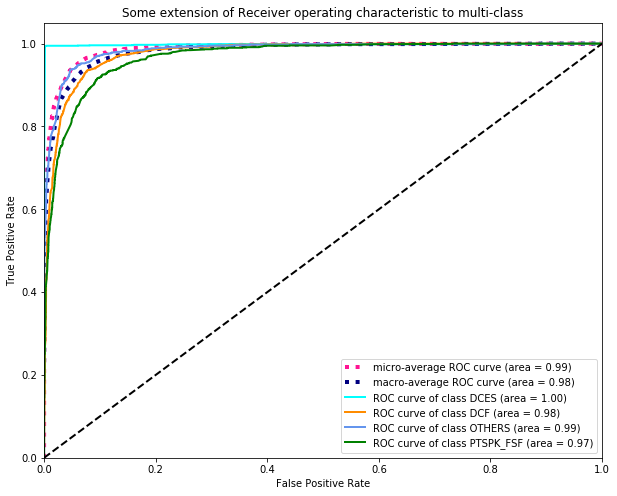

In [24]:
'''use ROC_AUC class to plot ROC curve for each category in 1st classifier (XGBoost)'''
RA1_xgb = ROC_AUC_printer(y_test, y_score_xgb)
fpr, tpr, roc_auc = RA1_xgb.calc(ConfMatrix_xgb.index)
RA1_xgb.Plot(fpr, tpr, roc_auc, ConfMatrix_xgb.index)

Text(0, 0.5, 'Feature Importance Score')

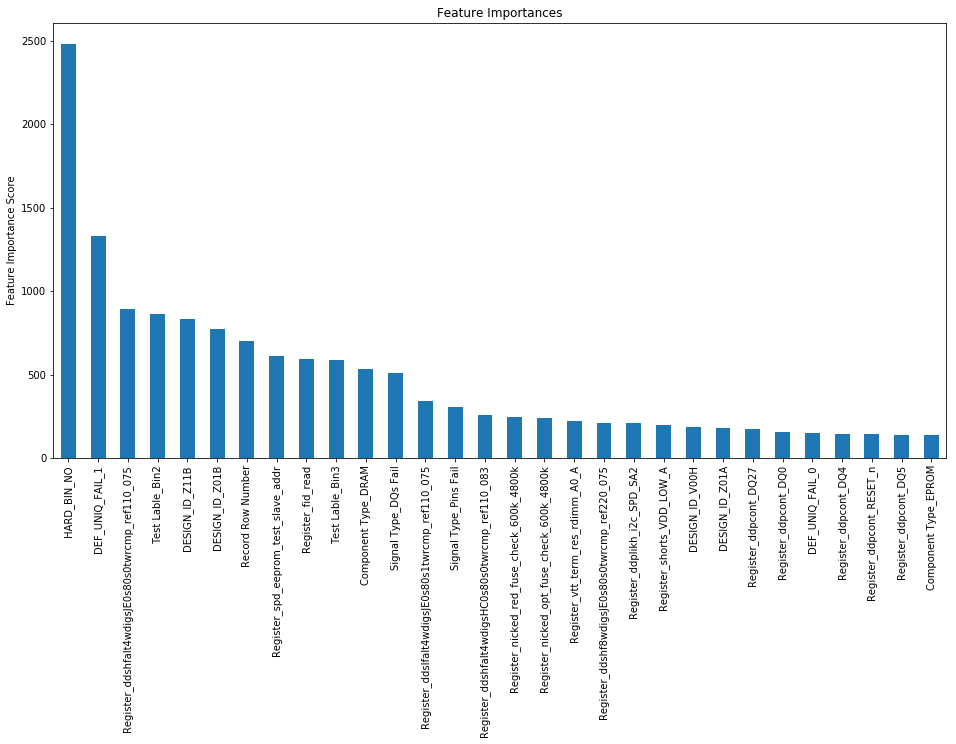

In [25]:
'''show the feature importance for the 1st classifier (XGBoost)'''
ImportanceSeries = pd.Series(clf_xgb.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
#print (ImportanceSeries.iloc[:20])
ImportanceSeries.iloc[:30].plot(kind='bar', title='Feature Importances', figsize = (16, 8), fontsize = 10)
plt.ylabel('Feature Importance Score')


**<font color=IndianRed size=5>
    Part 4: Data preprocess for the 2nd classifier
</font>**


<font color=Black size=4>
    Data Preprocess steps for the 2nd classifier are:
        
    1. use GetTrainSet() to get the 2nd training set from the 1st training set. (labels = OTHERS in 1st training set)
    
    2. use GetTestSet() to get the 2nd test set from the predicted results of lst classifier. 
    (In 1st test set, part of samples will be classified into "OTHERS" category, those samples will be treated as the 2nd test set)
    
    3. drop the features with std = 0 in 2nd training set. The features in 2nd test set should 
    be the same with those in 2nd training set.
    
    4. record the sample number in 2nd test set. (Test Number 1)
    
    5. drop the samples with "PTSPK_FSF', 'DCF', 'DCES" as their actual labels. 
    Because some sample are dropped, the sample number will change. Record the sample number in 2nd test set now. (Test Number 2)
    
    6. Combine the labels of samples in small categories into one category call "SMALLOTHERS".
    
    7. The sample number of "SMALLOTHER" may be much larger than that of other categories. 
    Oversampling is used to deal with the unbalanced problem. Now the preprocess is completed.
</font>

In [26]:
"""
@Class Name: DataPreprocessor_2ndClassifer
@use: prepare training data set and test data set for the second classifier
"""
class DataPreprocessor_2ndClassifer():    
    def GetTrainSet(self, x_train, y_train, OriginalLabels):
        """
        @function: GetTrainSet
        @input:
            1. x_train, feature matrix in training set for 1st classifier
            2. y_train, labels in training set for 1st classifier
            3. OriginalLabels, original labels without combination
        @return: 
            1. x_train_2nd: feature matrix in training set for 2nd classifier
            2. y_train_2nd: labels in training set for 2nd classifier

        @use: to get the training set for 2nd classifier.
                The training set for the second classifier contains samples with "OTHERS" as labels in the training set of the first classifier.
                Select training set according to labels and MID (MID in training set of the first classifier, Labels = OTHERS).
        """ 

        OthersMIDList_train = y_train[y_train == 'OTHERS'].index # get the 2nd train set index
        x_train_2nd = x_train.loc[OthersMIDList_train] # get the feature matrix for 2nd train set
        y_train_2nd = OriginalLabels.loc[OthersMIDList_train] # get the labels for 2nd train set
#         x_train_2nd.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\x_train.csv')
#         y_train_2nd.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\y_train.csv')
        return x_train_2nd, y_train_2nd
    
    def GetTestSet(self, x_test, OriginalLabels, y_pred):
        """
        @function: GetTrainSet
        @input:
            1. x_test, feature matrix in test set for 1st classifier
            2. OriginalLabels, original labels without combination
            3. y_pred, model predicted results
        @return: 
            1. x_test_2nd: feature matrix in test set for 2nd classifier
            2. y_test_2nd: labels in test set for 2nd classifier

        @use: to get the test set for 2nd classifier.
            The test set for the second classifier contains the samples with "OTHERS" as labels from the predictions of the first classifier.
            Select test set according to labels and MID (MID in first classifier's test set, predicted labels = OTHERS).
        """ 
      
        OthersMIDList_test = y_pred[y_pred == 'OTHERS'].index # get the test set index
        x_test_2nd = x_test.loc[OthersMIDList_test]
        y_test_2nd = OriginalLabels.loc[OthersMIDList_test]
#         x_test_2nd.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\x_test.csv')
#         y_test_2nd.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\y_test.csv')
        return x_test_2nd, y_test_2nd
    
    def CombineLabels(self, y_train_2nd, y_test_2nd):
        """
        @function: CombineLabels
        @input:
            1. y_train_2nd, labels in training set for 2nd classifier
            2. y_test_2nd: labels in test set for 2nd classifier
 
        @return: 
            1. y_trian_comb: labels in training set for 2nd classifier (after combining small categories)
            2. y_test_comb: labels in training set for 2nd classifier (after combining small categories)

        @use: to combine small categories in labels. Criteria for Small Categories in 2nd classifier: sample number < 100 in training set. 
            
        """ 
        y_train_comb = y_train_2nd.copy()
        y_test_comb = y_test_2nd.copy()
        LabelCounts = y_train_comb.value_counts()
        CommonLabelList = list(LabelCounts[LabelCounts>100].index) # find the categories whose sample number > 100, treat those categories as common classes
        
        '''use "SMALLOTHERS" to replace the labels for the samples not in common categories'''
        for i in range(y_train_2nd.shape[0]):
            if y_train_2nd.iloc[i] not in CommonLabelList:
                y_train_comb[i] = 'SMALLOTHERS'
        for i in range(y_test_2nd.shape[0]):
            if y_test_2nd.iloc[i] not in CommonLabelList:
                y_test_comb[i] = 'SMALLOTHERS'
        return y_train_comb, y_test_comb
    
    
    def Oversampling(self, x_train, y_train, smallcrierion = 600):
        """
        @function: Oversampling
        @input:
            1. y_train, labels in training set for 2nd classifier
            2. y_test: labels in test set for 2nd classifier
            3. smallcrierion: Criteria for Small Categories. Default number is 600.
 
        @return: 
            1. FinalFeatures: Feature matrix in training set after over sampling 
            2. FinalLabels: labels in training set after over sampling 

        @use: to oversample the samples in small categories in training set to dealing with the data unbalance problem.
        """            
        
        """
        solution:
            1. find the small category labels whose sample number < smallcrierion. 
            2. get the label elements according to the small category labels
            3. use a loop to duplicate samples one category by one category.
                In each loop step:
                    a. copy the labels several times utill the sample number exceeds the small crierion. 
                    b. add a serial number on the duplicates (Example: original index: 1CFC721C, first copy:1CFC721C_1, second copy:1CFC721C_2)
                    c. copy the corresponding feature matrix according to the index of labels
        """
        LabelCounts = y_train.value_counts() # get the count number of each label
        print ('------------before oversampling-----------')
        print (LabelCounts)
        LabelsAfterDuplicate = pd.Series()
        FeaturesAfterDuplicate = pd.DataFrame()
        SmallLabels = LabelCounts[LabelCounts < smallcrierion] # find the label list of small categories (sample number < smallcrierion) 
        IndexNeedDuplicate = y_train[y_train.isin(SmallLabels.index)] 
        groups = IndexNeedDuplicate.groupby(IndexNeedDuplicate)
        for name, group in groups:
            DuplicateTime = ceil(smallcrierion / group.shape[0]) # 
            for i in range(DuplicateTime):
                DuplicateSeries = group.copy()
                DuplicateIndex = DuplicateSeries.index + '_' + str(i + 1)
                DuplicateSeries.index = DuplicateIndex
                LabelsAfterDuplicate = pd.concat([LabelsAfterDuplicate, DuplicateSeries])
                #print (LabelsAfterDuplicate)
                '''duplicate the feature vectors for small classes'''
                DuplicateFeatures = x_train.loc[group.index].copy()
                DuplicateFeatures.index = DuplicateIndex
                FeaturesAfterDuplicate = pd.concat([FeaturesAfterDuplicate, DuplicateFeatures])
        LabelSmallOthers = y_train[y_train == 'SMALLOTHERS']
        FeatureSmallOthers = x_train.loc[LabelSmallOthers.index]
        
        FinalLabels = pd.concat([LabelSmallOthers, LabelsAfterDuplicate])
        FinalFeatures = pd.concat([FeatureSmallOthers, FeaturesAfterDuplicate])
        print ('-----------After oversampling-------------')
        print (FinalLabels.value_counts())
        return FinalFeatures, FinalLabels
    
    def DropCommon(self, x_test, y_test):
        """
        @function: DropPTSPK_FSF_DCF
        @input:
            1. x_test, frature matrix in training set for 2nd classifier
            2. y_test: labels in test set for 2nd classifier
 
        @return: 
            1. x_test_afterdrop:frature matrix in 2nd training set after dropping the samples with PTSPK_FSF, DCF, DCES as labels
            2. y_test_afterdrop: labels in 2nd training set after dropping the samples with PTSPK_FSF, DCF, DCES as labels

        @use: to drop the samples in 2nd training set whose labels belong to common labels.
        """ 
        DropLabels = ['PTSPK_FSF', 'DCF', 'DCES']
        y_test_afterdrop = y_test[~y_test.isin(DropLabels)]
        x_test_afterdrop = x_test.loc[y_test_afterdrop.index]
        return x_test_afterdrop, y_test_afterdrop
        
    def SaveData(self, x_train, x_test, y_train, y_test):
        """
        @function: SaveData
        @input:
            1. x_train, feature matrix in 2nd training set
            2. x_test, feature matrix in 2nd test set
            3. y_train, labels in 2nd training set
            4. y_test, lables in 2nd test set

        @use: to save training set and test set for the 2nd classifier.
        """
        x_train.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\x_train.csv')
        y_train.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\y_train.csv')
        x_test.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\x_test.csv')
        y_test.to_csv(r'C:\dataset\Module FA Reject Code\classifer2\y_test.csv')
        

In [27]:
'''start data preprocess for the 2nd classifier'''

'''step1: use GetTrainSet() to get the 2nd training set from the 1st training set. (labels = OTHERS in 1st training set)'''
DP_2nd = DataPreprocessor_2ndClassifer()
x_train_2nd, y_train_2nd = DP_2nd.GetTrainSet(x_train, y_train, df_regroup['Reject Code']) # training set for 2nd classifier contains samples with OTHERS labels in 1st training set

'''step2: use GetTestSet() to get the 2nd test set from the predicted results of lst classifier. '''
y_pred = pd.Series(y_pred_xgb) # convery y_pred to series in order to add index
y_pred.index = y_test.index
x_test_2nd, y_test_2nd = DP_2nd.GetTestSet(x_test, df_regroup['Reject Code'], y_pred) # test set for 2nd classifier contains samples which are predicted into OTHERS category by 1st classifier

'''setp3: drop the features with std = 0 in 2nd training set. The features in 2nd test set should be the same with those in 2nd training set'''
x_train_2nd_afterFilter = FF.SelectFeature(x_train_2nd) # drop the feature with std = 0 in 2nd training set
x_test_2nd_afterFilter = x_test_2nd.loc[:, x_train_2nd_afterFilter.columns] # the features in 2nd test set should be the same with those in 2nd training set

'''step4: record the sample number in 2nd test set. (Test Number 1)'''
TestRowNum1 = x_test_2nd_afterFilter.shape[0]

'''step5: drop the samples with "PTSPK_FSF', 'DCF', 'DCES" as their actual labels.'''
x_test_2nd_afterDrop, y_test_2nd_afterDrop = DP_2nd.DropCommon(x_test_2nd_afterFilter, y_test_2nd)
TestRowNum2 = x_test_2nd_afterDrop.shape[0]

'''step6: Combine the labels of samples in small categories into one category call "SMALLOTHERS".'''
y2_train_comb, y2_test_comb = DP_2nd.CombineLabels(y_train_2nd, y_test_2nd_afterDrop)

'''step7: Oversampling'''
x_train_OverSample, y_train_OverSample = DP_2nd.Oversampling(x_train_2nd_afterFilter, y2_train_comb)

feature number before filter: (1813, 778)
feature number after filter: (1813, 400)
------------before oversampling-----------
SMALLOTHERS    841
TF             227
LF             165
EC1            160
PDC1           152
PDC2           151
CL1            117
Name: Reject Code, dtype: int64
-----------After oversampling-------------
SMALLOTHERS    841
CL1            702
TF             681
LF             660
EC1            640
PDC1           608
PDC2           604
dtype: int64



**<font color=IndianRed size=5>
    Part 5: Perform machine learning algorithms to build the 2nd classifier
</font>**


<font color=Black size=4>
    The steps in Modeling Part for the 2nd classifier are:
        
    1. Perform Logistic Regression.
    
    2. Plot ROC curve for LR.
    
    3. Perform SVM.
    
    4. Use gridsearchCV to find the best parameters for SVM. 
    
    5. Plot ROC curve for SVM.
    
    6. LR shows a better accuracy than SVM. Choose LR as the 2nd classifier.
    
    7. Show the feature importance of LR.
    
    Note:
    a. I tried XGBoost but it predicted very bad results on the 2nd test set
    b. I tried Oversampling on the 2nd training set, but the classifier shows a lower accuracy on the 2nd test set, so I dropped the oversampling step on the 2nd training set.
    c. The accuracy of the 2nd classifier should

</font>

In [28]:
'''perform the LR model to predict the FA defect code. The training has been oversampled'''
LRP2 = LRPredictor(x_train_OverSample, x_test_2nd_afterDrop, y_train_OverSample, y2_test_comb)
Model2_LR, ConfMatrix2_LR, ClassReport2_LR, y_pred2_LR, y2_score_LR = LRP2.calc()

Accuracy is: 0.4780058651026393
ConfMatrix is:
             CL1  EC1  LF  PDC1  PDC2  SMALLOTHERS  TF
CL1           18   10   0     4     5           11   0
EC1            3   53   0     6     2            7   0
LF             0    1   7     0     0            1   5
PDC1          13    1   0    38    11           17   0
PDC2          15    0   0    14    25           11   0
SMALLOTHERS   69   53  10    20    25          150  37
TF             0    2   3     0     0            0  35
Classification_report is
              precision    recall  f1-score   support

         CL1       0.15      0.38      0.22        48
         EC1       0.44      0.75      0.55        71
          LF       0.35      0.50      0.41        14
        PDC1       0.46      0.47      0.47        80
        PDC2       0.37      0.38      0.38        65
 SMALLOTHERS       0.76      0.41      0.53       364
          TF       0.45      0.88      0.60        40

   micro avg       0.48      0.48      0.48       682


In [29]:
'''perform the LR model to predict the FA defect code. The training has not been oversampled'''
LRP2 = LRPredictor(x_train_2nd_afterFilter, x_test_2nd_afterDrop, y2_train_comb, y2_test_comb)
Model2_LR, ConfMatrix2_LR, ClassReport2_LR, y_pred2_LR, y2_score_LR = LRP2.calc()

Accuracy is: 0.6129032258064516
ConfMatrix is:
             CL1  EC1  LF  PDC1  PDC2  SMALLOTHERS  TF
CL1            0    6   0     1     0           41   0
EC1            0   30   0     6     0           35   0
LF             0    1   4     0     0            2   7
PDC1           0    1   0    37     4           38   0
PDC2           1    0   0    12    12           40   0
SMALLOTHERS    0   20   2     6     6          299  31
TF             0    0   0     0     0            4  36
Classification_report is
              precision    recall  f1-score   support

         CL1       0.00      0.00      0.00        48
         EC1       0.52      0.42      0.47        71
          LF       0.67      0.29      0.40        14
        PDC1       0.60      0.46      0.52        80
        PDC2       0.55      0.18      0.28        65
 SMALLOTHERS       0.65      0.82      0.73       364
          TF       0.49      0.90      0.63        40

   micro avg       0.61      0.61      0.61       682


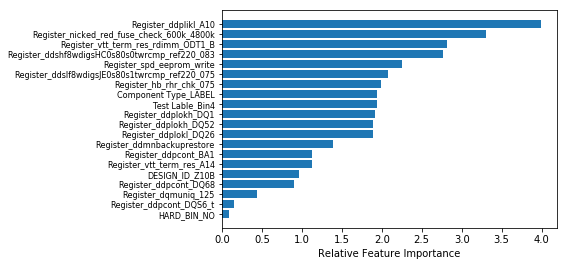

In [30]:
'''show the feature importance for the 2nd LR model. The training has not been oversampled'''
LRP2.PlotFeatureImportance(x_train_2nd_afterFilter.columns, Model2_LR, 20)

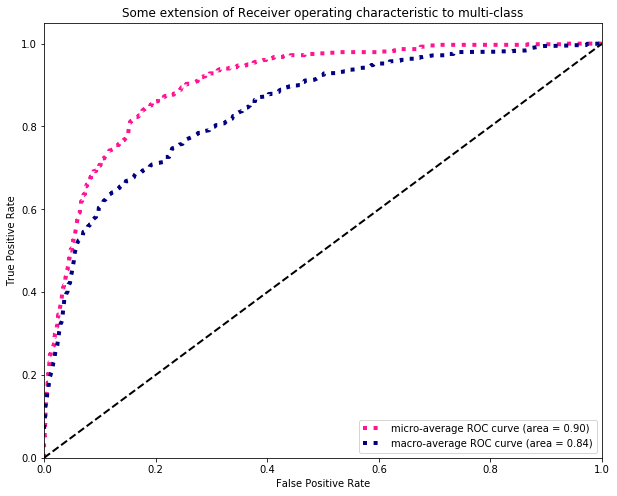

In [31]:
'''plot the ROC curve for the 2nd classifier (logistic regression)'''
RA_2nd_LR = ROC_AUC_printer(y2_test_comb, y2_score_LR) # 
fpr, tpr, roc_auc = RA_2nd_LR.calc(ConfMatrix2_LR.index)
RA_2nd_LR.Plot2(fpr, tpr, roc_auc)

In [32]:
"""
@Class Name: SVMPredictor()
@use: use svm to build the second classifier and predict the FA defect code for the samples in "OTHERS" category 
"""
class SVMPredictor():    
    def FindBestParam(self, x_train,x_test,y_train,y_test):
        """
        @function: FindBestParam
        @input:
            1. x_train, feature matrix in training set for 2nd classifier
            2. x_test, feature matrix in test set for 2nd classifier
            3. y_train, labels in training set for 2nd classifier
            4. y_test: labels in test set for 2nd classifier
 
        @return: 
            1. grid, GridSearchCV object, contain the best parameters

        @use: to drop the samples in 2nd training set whose labels belong to common labels.
        """ 
        grid = GridSearchCV(SVC(decision_function_shape='ovr'), 
                            param_grid = {"C":[0.1, 1, 10], "gamma": [0.01, 0.1, 1, 10]}, cv = 4, verbose=5, n_jobs = 6)
        grid.fit(x_train, y_train)
        print("The best parameters are %s with a score of %0.2f"% (grid.best_params_, grid.best_score_))
        clf = SVC(C = grid.best_params_['C'], gamma = grid.best_params_["gamma"], 
                  decision_function_shape='ovr')
        return grid
        
    def Fit(self, params, x_train,x_test,y_train,y_test):
        """
        @function: Fit
        @input:
            1. params, parameters used in SVM model
            2. x_train, feature matrix in training set for 2nd classifier
            3. x_test, feature matrix in test set for 2nd classifier
            4. y_train, labels in training set for 2nd classifier
            5. y_test, labels in test set for 2nd classifier
 
        @return: 
            1. ConfMatrix: confusion matrix of test set
            2. ClassReport: a matrix include precision, recall, F1-score of each category
            3. y_pred: predicted labels of test set
            4. y_score: probability in every category, predicted by the fitted model. It is used to plot the ROC_AUC figure.

        @use: to drop the samples in 2nd training set whose labels belong to common labels.
        """ 
        clf = SVC(C = params['C'], gamma = params["gamma"],probability=True,
                  decision_function_shape='ovr')
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test) # predict the labels
        y_score = clf.predict_proba(x_test)# get the probability for each category
        classname = clf.classes_ # get the class name list of prediction
        Accuracy = metrics.accuracy_score(y_test, y_pred) # get the accuracy 
        ConfMatrix = metrics.confusion_matrix(y_test, y_pred)
        
        '''convert confusion matrix into dataframe to add column name and index'''
        ConfMatrix = pd.DataFrame(ConfMatrix)
        ConfMatrix.index = classname
        ConfMatrix.columns = classname        
        ClassReport = metrics.classification_report(y_test, y_pred)
        print ('Accuracy is:', Accuracy)
        print ('ConfMatrix is:')
        print (ConfMatrix)
        print ('classification_report is')
        print (ClassReport)
        return ConfMatrix, ClassReport, y_pred, y_score,  clf

In [33]:
'''use SVM to predict FA defect code for the 2nd test set'''
SVMP = SVMPredictor()
GridSearch_SVM = SVMP.FindBestParam(x_train_2nd_afterFilter, x_test_2nd_afterDrop, y2_train_comb, y2_test_comb)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed:   46.2s finished


The best parameters are {'C': 1, 'gamma': 0.1} with a score of 0.60


In [34]:
ConfMatrix_svm, ClassReport_svm, y_pred_svm, y_score_svm, clf_svm = SVMP.Fit(GridSearch_SVM.best_params_, x_train_2nd_afterFilter, x_test_2nd_afterDrop, y2_train_comb, y2_test_comb)

Accuracy is: 0.6217008797653959
ConfMatrix is:
             CL1  EC1  LF  PDC1  PDC2  SMALLOTHERS  TF
CL1            0    3   0     0     0           45   0
EC1            0   14   0     5     0           52   0
LF             0    0   4     0     0            5   5
PDC1           0    0   0    39     0           41   0
PDC2           0    0   0    14    10           41   0
SMALLOTHERS    0    4   3     5     1          322  29
TF             0    0   0     0     0            5  35
classification_report is
              precision    recall  f1-score   support

         CL1       0.00      0.00      0.00        48
         EC1       0.67      0.20      0.30        71
          LF       0.57      0.29      0.38        14
        PDC1       0.62      0.49      0.55        80
        PDC2       0.91      0.15      0.26        65
 SMALLOTHERS       0.63      0.88      0.74       364
          TF       0.51      0.88      0.64        40

   micro avg       0.62      0.62      0.62       682


c:\development\1stprj\1stprj\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


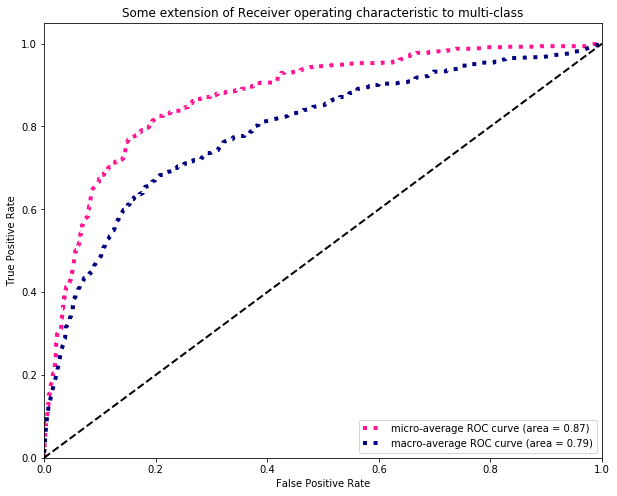

In [538]:
'''plot the ROC curve for the 2nd classifier (SVM)'''
RA_SVM = ROC_AUC(y2_test_comb, y_score_svm) # 
fpr, tpr, roc_auc = RA_SVM.calc(ConfMatrix_svm.index)
RA_SVM.Plot2(fpr, tpr, roc_auc)

In [35]:
'''Total accuracy is calculated by correctly classified sample number / '''
(14+4+39+10+322+35+1731+2012+1152) / 6258

0.8499520613614573